# Lublin House Prices Prediction

**Author:** Davyd Antoniuk

## 1. Introduction

**Project Goal:** Predicting House Prices in Lublin Using Machine Learning & Deep Learning

This project aims to build an accurate model for predicting house prices in Lublin by comparing various machine learning and deep learning algorithms. The dataset was scraped from [Otodom](https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/lubelskie/lublin/lublin/lublin?viewType=listing&page=), then cleaned and preprocessed, including handling missing values and balancing price distribution.

Various models were trained and evaluated to identify the best-performing approach for price prediction, ensuring high accuracy and reliability in real estate price estimation.

## 2. Data Collection & Preprocessing

In [1]:
from help_functions import * 
from help_functions import evaluate_model, check_normality, check_feature_importance, detect_outliers_iqr, winsorize_series, get_kdist_plot, compute_weights, plot_metric_comparison

c:\Users\davyd\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File `help_functions.py` contains all necessary libraries and functions used in this project.\
File link: https://github.com/davydantoniuk/lublin-house-price-predict/blob/main/help_functions.py

### 2.1 Data Scraping

The dataset was collected by scraping house listings from the [Otodom](https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/lubelskie/lublin/lublin/lublin?viewType=listing&page=) website using `R` with the libraries `rvest`, `dplyr`, and `stringr`. The scraping script is available in the `scraper/` folder, and the collected dataset is stored in `data/`.

### 2.2 Dataset Overview

In [2]:
data = pd.read_csv('data/houses_data.csv')
data.head()

,Price,Name,Rooms,Area,Floor,Region,Year,Elevator
0,567 000 zł,4-pokojowe LSM bez prowizji,4 pokoje,52.5 m²,3 piętro,Rury,brak informacji,nie
1,728 500 zł,Idealne mieszkanie 4 Pokoje ! 2 balkony ! Okazja,4 pokoje,77.5 m²,3 piętro,Czechów Północny,2025,tak
2,668 360 zł,Active City etap V | mieszkanie 4-pok. | D1_2_17,4 pokoje,68.2 m²,2 piętro,Wrotków,2026,tak
3,833 414 zł,"Mieszkanie, rynek pierwotny, KONCERTOWA 42",4 pokoje,76.46 m²,1 piętro,Czechów Południowy,2023,tak
4,696 500 zł,4 pokoje na nowym osiedlu blisko Centrum.,4 pokoje,79.6 m²,NaN,Kośminek,2025,tak


- Price – Listing price of the house/apartment.
- Name – Title of the listing.
- Rooms – Number of rooms in the property.
- Area – Total area in square meters.
- Floor – Floor number (if applicable).
- Region – Region of the property.
- Year – Year of construction.
- Elevator – Indicates if the building has an elevator (Yes(*tak*)/No(*nie*)).

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     3182 non-null   object
 1   Name      3182 non-null   object
 2   Rooms     3182 non-null   object
 3   Area      3182 non-null   object
 4   Floor     3121 non-null   object
 5   Region    3182 non-null   object
 6   Year      3182 non-null   object
 7   Elevator  3182 non-null   object
dtypes: object(8)
memory usage: 199.0+ KB


The dataset consists of 3182 entries and 8 columns, with all features stored as object (string) type. To ensure proper analysis and modeling, numerical columns need to be converted to their appropriate data types.

In [4]:
print("\nUnique values in each column (excluding 'Name', 'Price' and 'Area'):")
for column in data.columns:
    if column not in ['Name', 'Price', 'Area']:
        unique_values = data[column].unique()
        print(f"{column}: {unique_values}")


Unique values in each column (excluding 'Name', 'Price' and 'Area'):
Rooms: ['4 pokoje' '2 pokoje' '3 pokoje' '1 pokój' '5 pokoi' '6 pokoi'
 '10+ pokoi' '7 pokoi']
Floor: ['3 piętro' '2 piętro' '1 piętro' nan '10+ piętro' '10 piętro' '4 piętro'
 'parter' '6 piętro' '5 piętro' '9 piętro' '7 piętro' '8 piętro'
 'suterena' 'poddasze']
Region: ['Rury' 'Czechów Północny' 'Wrotków' 'Czechów Południowy' 'Kośminek'
 'Wieniawa' 'Ponikwoda' 'Śródmieście' 'Bronowice' 'Węglin Południowy'
 'Dziesiąta' 'Tatary' 'Felin' 'Kalinowszczyzna' 'Sławin' 'Czuby Północne'
 'Konstantynów' 'Szerokie' 'Czuby Południowe' 'Stare Miasto'
 'Za Cukrownią' 'Zemborzyce' 'Węglin Północny' 'Hajdów-Zadębie']
Year: ['brak informacji' '2025' '2026' '2023' '2015' '1980' '1982' '2008' '2024'
 '2018' '2003' '2021' '1976' '1963' '2017' '1969' '2000' '1978' '1975'
 '1983' '1993' '1974' '1995' '2022' '1994' '1897' '1986' '1984' '2010'
 '1988' '1973' '1996' '1967' '1972' '1964' '1998' '2014' '1990' '1977'
 '2005' '2012' '2016' '1

The `Year` column contains the unique value *brak informacji*, which should be replaced with **NaN**. Additionally, it includes unrealistic values like *1650*, *1* and *87*, which need to be handled appropriately. Let's check that observations

In [5]:
data[data["Year"].isin(["1650", "1", "87"])]

,Price,Name,Rooms,Area,Floor,Region,Year,Elevator
399,830 000 zł,"Stare Miasto, Idealne Pod Wynajem Krótkoterminowy",3 pokoje,65 m²,2 piętro,Stare Miasto,1650,nie
684,524 000 zł,Trzypokojowe mieszkanie piętro: 1/4,3 pokoje,62 m²,1 piętro,Czuby Północne,1,nie
2559,559 000 zł,Mieszkanie dla rodziny w świetnej lokalizacji,3 pokoje,66 m²,NaN,Czuby Północne,87,nie


The value *87* could likely represent *1987*, so it can be corrected accordingly. However, *1* and *1650* are difficult to interpret, making it more appropriate to replace them with `NaN` for better data consistency.

Additionally, the `Price` column also contains missing values, like *Zapytaj o cenę*, which should be replaced with **NaN**.

In [6]:
data[data["Price"] == "Zapytaj o cenę"].head(1)

,Price,Name,Rooms,Area,Floor,Region,Year,Elevator
33,Zapytaj o cenę,Narcyzowe Wzgórza II | mieszkanie 2-pok. | C_45,2 pokoje,32.33 m²,1 piętro,Ponikwoda,2026,tak


### 2.3 Data Cleaning

Let's firstly delete `Name` column, as it does not provide any valuable information for the model.\
I scraped that column to verify if scrapper works correctly, because in the names there are often information about the number of rooms, area, region and it was easier to check if the scrapper works correctly.

In [7]:
data = data.drop("Name", axis=1)

#### 2.3.1 Data type conversions

In [8]:
# Replace 'Zapytaj o cenę' with NaN
data['Price'] = data['Price'].replace('Zapytaj o cenę', np.nan)

# Remove non-numeric characters, replace commas with dots, and convert to float, while keeping NaN values
data['Price'] = data['Price'].str.replace('\xa0', '').str.replace('zł', '').str.replace(',', '.').astype('float32')

In [9]:
# Remove non-numeric characters and convert 'Area' to float
data['Area'] = data['Area'].str.replace(' ', '').str.replace('m²', '').astype('float32')

In [10]:
# Replace 'brak informacji' with NaN in 'Year' column
data['Year'] = data['Year'].replace('brak informacji', np.nan)

# Replace '87' with 1987 and '1' with NaN in 'Year' column
data['Year'] = data['Year'].replace({'87': 1987, '1': np.nan, '1650': np.nan})

# Convert 'Year' to integer, while keeping NaN values
data['Year'] = data['Year'].astype(float).astype('Int32')

In [11]:
# Convert 'Elevator' column to 0 if 'nie' and 1 if 'tak'
data['Elevator'] = data['Elevator'].replace({'nie': 0, 'tak': 1}).astype('int32')

In [12]:
# Count the number of rows for each unique value in 'Rooms' column
room_counts = data['Rooms'].value_counts()
print("Number of rows for each unique value in 'Rooms' column:")
print(room_counts)

Number of rows for each unique value in 'Rooms' column:
Rooms
3 pokoje     1364
2 pokoje     1124
4 pokoje      404
1 pokój       232
5 pokoi        46
6 pokoi         7
7 pokoi         3
10+ pokoi       2
Name: count, dtype: int64


There are only two observations in the "Rooms" column that have 10+ rooms, so let's replace them with 10.

In [13]:
# Replace '10+ pokoi' with '10 pokoi' in 'Rooms' column
data['Rooms'] = data['Rooms'].replace('10+ pokoi', '10 pokoi')

# Extract numeric part and convert 'Rooms' to integer
data['Rooms'] = data['Rooms'].str.extract('(\d+)').astype('int32')

In [14]:
# Reorder columns
data = data[['Price', 'Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']]

Simple RandomForest model on the dataset with missing values.

In [15]:
data_rf1 = data.copy()

# Drop rows with missing values in 'Price' column
data_rf1 = data_rf1.dropna(subset=['Price'])

# One-hot encode 'Floor' and 'Region' columns
data_rf1 = pd.get_dummies(data_rf1, columns=['Floor', 'Region'], drop_first=True)

# Define features and target
features = data_rf1.drop('Price', axis=1)
target = data_rf1['Price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model1.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model1.predict(X_test)

# Evaluate the model
rf1_r2, rf1_mae, rf1_mse, rf1_rmse, rf1_mape, rf1_rmsle = evaluate_model(y_test, y_pred)
print(f"R^2: {rf1_r2:.4f}")
print(f"MAE: {rf1_mae:.2f}")       
print(f"RMSE: {rf1_rmse:.2f}")
print(f"MAPE: {rf1_mape:.2f}")
print(f"RMSLE: {rf1_rmsle:.4f}")

R^2: 0.8292
MAE: 44186.17
RMSE: 84052.60
MAPE: 6.93
RMSLE: 0.1128


The Random Forest model initially performed well despite missing values, achieving an $R^2$ score of 83%. The **MAE** of 44186 and **MAPE** of 6.93% suggest relatively low average errors, while the larger **RMSE** of 84052 meaning that a few predictions have very high deviations from the actual prices.

So, there is still *room for improvement*.

#### 2.3.2 Handling missing values

Let's look at how many missing values we have

In [16]:
# Assuming 'data' is your DataFrame
missing_data = data.isnull().sum()
print("Missing data in each column:")
print(missing_data)

Missing data in each column:
Price       401
Area          0
Elevator      0
Year        494
Rooms         0
Floor        61
Region        0
dtype: int64


Since `Price` is what the model is learning to predict, imputing it can create synthetic labels, which may harm the model's accuracy. So let's drop rows with missing values in the `Price` column.

In [17]:
# Drop rows with missing values in 'Price' column
data = data.dropna(subset=['Price'])

For missing values in `Year` and `Floor`, I will first handle them appropriately. Instead of using simple methods like *mean*, *median*, or *mode*, I will analyze the correlation matrix to explore relationships between features and determine if regression-based imputation is a better approach.

**Correlation matrix**

Since the `Floor` column is categorical, converting it directly to numerical values could mislead the model. A better approach is to use one-hot encoding for modeling. However, to analyze correlations and explore regression-based imputation, I will first create a temporary dataset where Floor is converted to numerical values to check the correlation matrix.

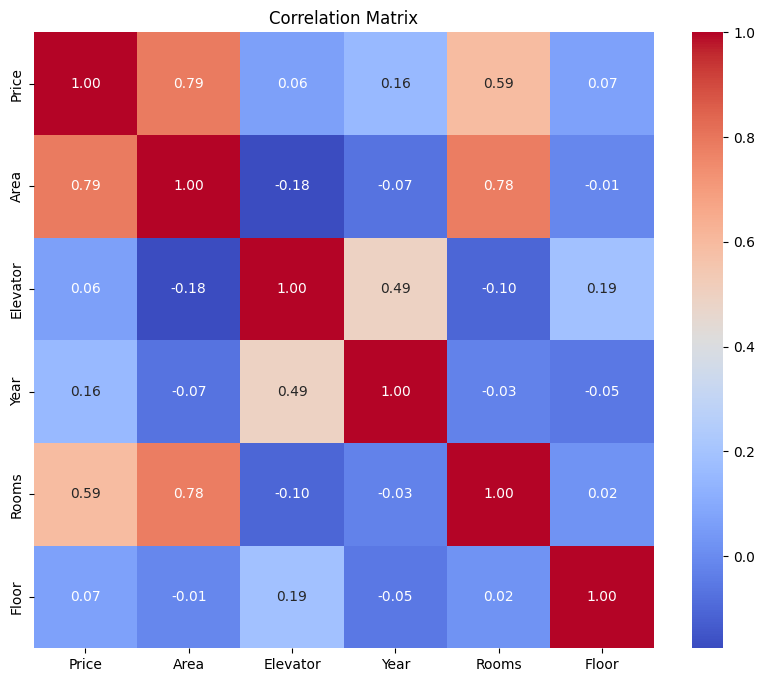

In [18]:
# Create a copy of the DataFrame
data_corr = data.copy(deep=True)
data_corr["Floor"] = data_corr["Floor"].str.extract('(\d+)').astype('Int32')

# Select only numeric columns
numeric_data = data_corr.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

The `Year` and `Floor` columns show very low correlation with other features, meaning that using **regression-based imputation** to predict their missing values would not be a reliable approach.\
Additionally, we observe *high correlations* between:
- `Price` and `Area` (0.79)
- `Price` and `Rooms` (0.59)
- `Rooms` and `Area` (0.78)

These correlations are logically expected, as larger properties typically have more rooms and higher prices. 

There is also a moderate correlation (0.49) between `Year` and `Elevator`, which suggests that newer buildings are more likely to have elevators. This is reasonable, as modern construction standards often include elevators, while older buildings may lack them.


To fill the missing values in Year and Floor, I will use a `KNN Imputer`, which leverages similar observations to estimate missing values.

Since **KNN Imputer** only works with numerical data, I will temporarily encode `Floor` as numbers, impute missing values, and then convert it back to its original categorical format. Additionally, it is important to one hot encode the `Region` column before **KNN imputation**, because **KNN Imputer** relies on distance-based calculations, which only work with numerical data. 

In [19]:
# Create a copy to preserve original data
data_processed = data.copy(deep = True)

# One-hot encode Region
region_dummies = pd.DataFrame()
if data_processed['Region'].dtype == 'object':
    region_dummies = pd.get_dummies(data_processed['Region'], prefix='Region', dtype=int)
    data_processed = pd.concat([data_processed.drop('Region', axis=1), region_dummies], axis=1)

# Ordinal encode Floor
floor_order = [
    'suterena', 'parter', '1 piętro', '2 piętro', '3 piętro',
    '4 piętro', '5 piętro', '6 piętro', '7 piętro', '8 piętro',
    '9 piętro', '10 piętro', '10+ piętro', 'poddasze'
]
floor_mapping = {floor: idx for idx, floor in enumerate(floor_order)}
data_processed['Floor_encoded'] = data_processed['Floor'].map(floor_mapping)
data_processed.drop('Floor', axis=1, inplace=True)

# Apply KNN Imputation
imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(data_processed)
data_imputed = pd.DataFrame(imputed_data, columns=data_processed.columns)

# Decode Floor
inverse_floor_mapping = {v: k for k, v in floor_mapping.items()}
data_imputed['Floor'] = data_imputed['Floor_encoded'].round().astype(int).map(inverse_floor_mapping)
data_imputed.drop('Floor_encoded', axis=1, inplace=True)

# Convert Year to int32
data_imputed['Year'] = data_imputed['Year'].round().astype(int)

# Revert Region encoding 
if not region_dummies.empty:
    region_cols = [col for col in data_imputed.columns if col.startswith('Region_')]
    data_imputed['Region'] = data_imputed[region_cols].idxmax(axis=1).str.replace('Region_', '')
    data_imputed.drop(columns=region_cols, inplace=True)

# Ensure correct dtypes
data_imputed['Floor'] = data_imputed['Floor'].astype('object')

# Reorder columns to match original structure
final_columns = ['Price', 'Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']
data_imputed = data_imputed[final_columns]

**Why k = 3 in KNN Imputer?**

I experimented with different values of `k` to find the optimal number of neighbors for the KNN Imputer. After building and evaluating model below with various `k` values, the best metrics were achieved with `k = 3`. Therefore, I used `k = 3` for the KNN Imputer.


In [20]:
data = data_imputed.copy(deep = True)

In [21]:
sum(data.isnull().sum())

0

Finally, we impute missing values and now we have a clean dataset with no missing values.

Now let's try again build a RandomForest model on the cleaned dataset and check if the results are better.

In [22]:
data_rf2 = data.copy()

# One-hot encode 'Floor' and 'Region' columns
data_rf2 = pd.get_dummies(data_rf2, columns=['Floor', 'Region'], drop_first=True)

# Define features and target
features = data_rf2.drop('Price', axis=1)
target = data_rf2['Price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model2.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model2.predict(X_test)

# Evaluate the model
rf2_r2, rf2_mae, rf2_mse, rf2_rmse, rf2_mape, rf2_rmsle = evaluate_model(y_test, y_pred)
print(f"R^2: {rf2_r2:.4f}")
print(f"MAE: {rf2_mae:.2f}")       
print(f"RMSE: {rf2_rmse:.2f}")
print(f"MAPE: {rf2_mape:.2f}")
print(f"RMSLE: {rf2_rmsle:.4f}")

R^2: 0.8382
MAE: 43551.67
RMSE: 81798.74
MAPE: 6.88
RMSLE: 0.1105


Although the model did not achieve significantly higher results after handling missing values, **KNN Imputation** still played a small role in improving both model performance and overall data quality 🚀

Additionally, let's check feature importance to understand which features have the most significant impact on the model's predictions.

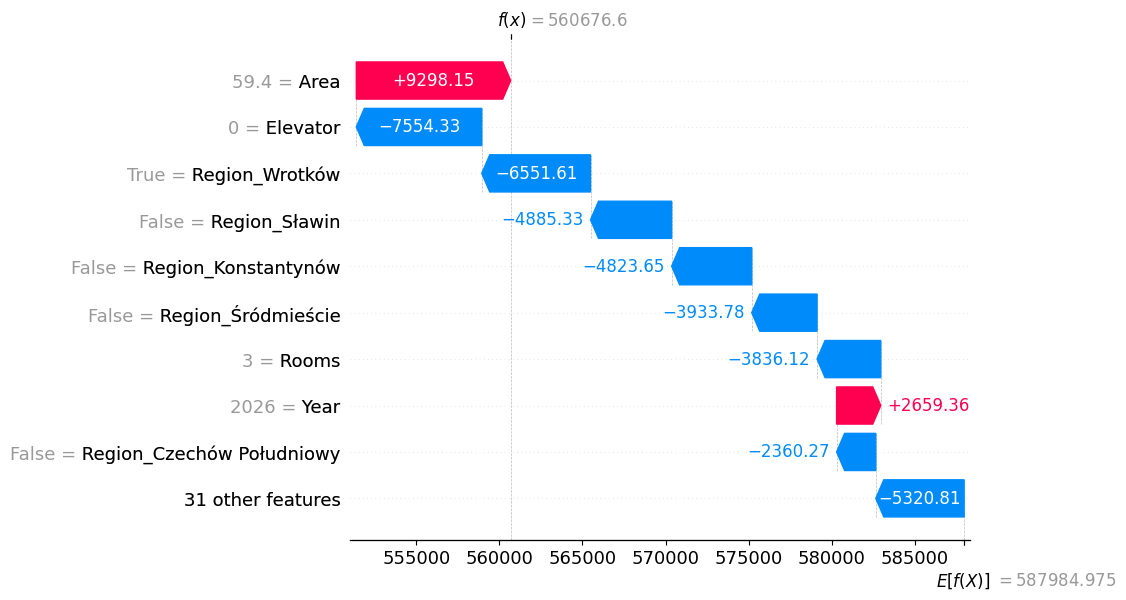

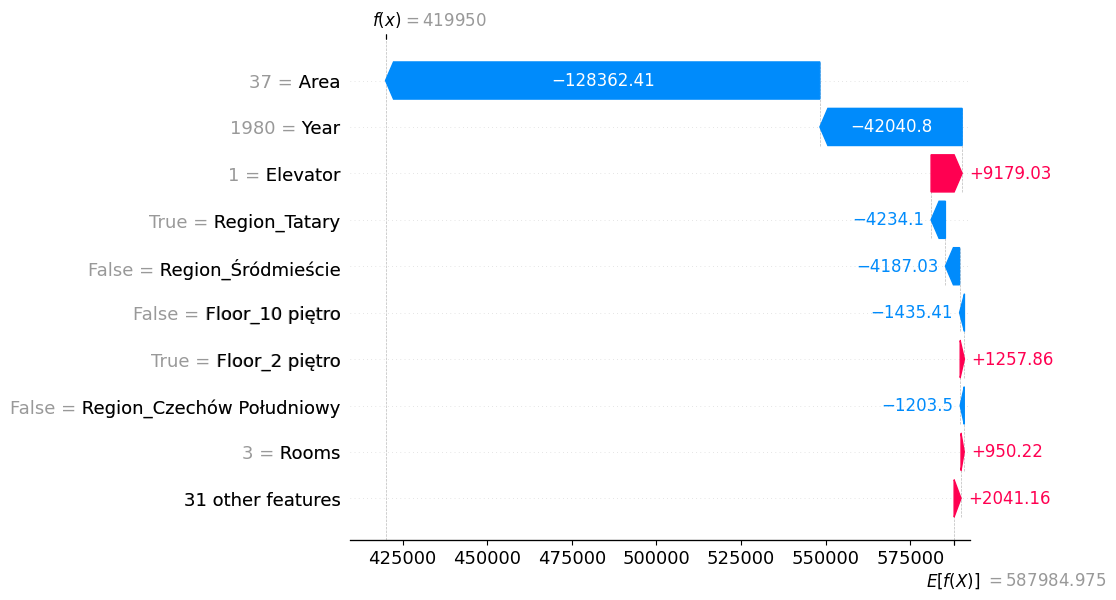

In [23]:
check_feature_importance(rf_model2, X_test, num_observations=2)

`Area` and `Year` have the highest importance in predicting price. `Elevator` also plays a significant role, with its presence generally contributing to a price increase.

`Region` and `Floor` show moderate importance, though lower than `Area`, `Year`, and `Elevator`. This suggests that while location and floor level matter, they are not the primary drivers of price variation.

`Rooms` have the lowest importance in two interesting cases, likely due to their high correlation with `Area`. Since `Area` already holds higher predictive power, the model relies on it more, reducing the relative importance of `Rooms`.

## 3. Exploratory Data Analysis

Data after cleaning and imputing missing values

In [24]:
data.head()

,Price,Area,Elevator,Year,Rooms,Floor,Region
0,567000.0,52.500000,0.0,2017,4.0,3 piętro,Rury
1,728500.0,77.500000,1.0,2025,4.0,3 piętro,Czechów Północny
2,668360.0,68.199997,1.0,2026,4.0,2 piętro,Wrotków
3,833414.0,76.459999,1.0,2023,4.0,1 piętro,Czechów Południowy
4,696500.0,79.599998,1.0,2025,4.0,3 piętro,Kośminek


### 3.1 Basic Statistics

Since we have already cleaned the data, we can now study it in more detail

Let's see basic statistics of the dataset

In [25]:
numerical_cols = ["Price", "Area", "Elevator", "Year", "Rooms"]

# Basic statistics for numerical columns
numerical_stats = data[numerical_cols].describe().round(2)

numerical_stats

,Price,Area,Elevator,Year,Rooms
count,2781.00,2781.00,2781.00,2781.00,2781.00
mean,589206.60,55.55,0.53,2002.23,2.70
std,200524.03,19.21,0.50,27.63,0.88
min,99000.00,13.50,0.00,1815.00,1.00
25%,465000.00,43.70,0.00,1981.00,2.00
50%,558360.00,53.39,1.00,2014.00,3.00
75%,668360.00,63.87,1.00,2024.00,3.00
max,2900000.00,314.00,1.00,2027.00,10.00


- **Price** \
    Prices range from 99,000 PLN to 2,900,000 PLN, with most listings falling between 465,000 PLN (25th percentile) and 668,360 PLN (75th percentile), indicating a moderate spread in property values. The high standard deviation (200,524 PLN) suggests significant price variation across listings. 
- **Area**\
    The average property size is 55.55 m², with most ranging between 43 m² and 64 m². There is moderate variation, but some large properties reach up to 314 m².
- **Elevator**\
    About 53% of properties have an elevator.
- **Year**\
    The median year (2014) is significantly higher than the mean (2002) due to the presence of older buildings dating back to 1815, which skews the average downward. Additionally, the years 2026 and 2027 indicate properties that are still under construction or planned for the future.
- **Rooms**\
    Most properties have 2 to 3 rooms, with an average of 2.7 rooms. The number of rooms ranges from 1 to 10, though larger apartments (5+ rooms) are less common. 

In [26]:
categorical_cols = ["Floor", "Region"]

# Basic statistics for categorical columns 
categorical_stats = pd.DataFrame({
    "Unique Values": data[categorical_cols].nunique(),
    "Most Common Value": data[categorical_cols].mode().iloc[0],
    "Frequency": data[categorical_cols].apply(lambda x: x.value_counts().iloc[0])
})

categorical_stats

,Unique Values,Most Common Value,Frequency
Floor,14,3 piętro,563
Region,24,Śródmieście,299


The dataset includes 14 unique floor levels, with "2 piętro" being the most common (564 listings). Among 24 regions, "Śródmieście" appears most frequently (299 listings).

### 3.2 Price and Area Distribution

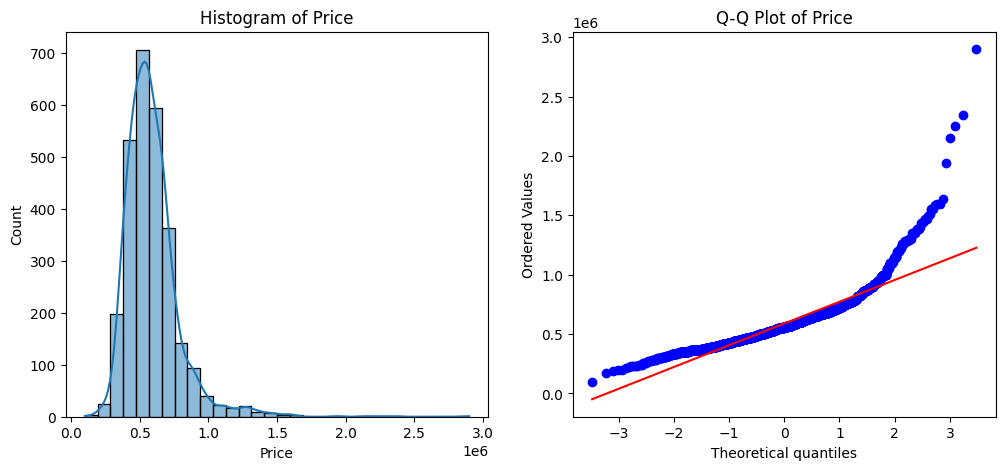

Normality Tests for Price:
  Shapiro-Wilk Test: W=0.8352, p-value=0.0000
  D'Agostino's K² Test: Stat=1689.5467, p-value=0.0000
  Reject null hypothesis for Shapiro-Wilk Test at alpha=0.05
  Reject null hypothesis for D'Agostino's K² Test at alpha=0.05
--------------------------------------------------


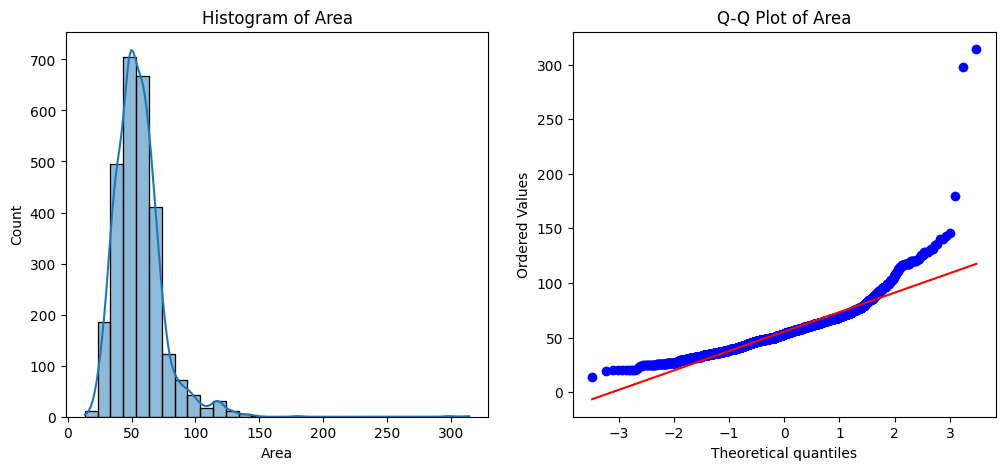

Normality Tests for Area:
  Shapiro-Wilk Test: W=0.8591, p-value=0.0000
  D'Agostino's K² Test: Stat=1856.4837, p-value=0.0000
  Reject null hypothesis for Shapiro-Wilk Test at alpha=0.05
  Reject null hypothesis for D'Agostino's K² Test at alpha=0.05
--------------------------------------------------


In [27]:
cols = ["Price", "Area"]
check_normality(data, cols)

Both `Price` and `Area` failed the normality tests. This indicates that these variables are skewed or contain outliers. On Q-Q plots, we can notice distanced points from the line, which confirms the presence of outliers. 

### 3.3 Regional Analysis

Number of unique values for each region.

In [28]:
data["Region"].value_counts()

Region
Śródmieście           299
Sławin                268
Ponikwoda             238
Wrotków               226
Czechów Północny      211
Czechów Południowy    207
Rury                  204
Węglin Południowy     174
Wieniawa              135
Dziesiąta             111
Kośminek              103
Czuby Północne         92
Kalinowszczyzna        82
Bronowice              81
Stare Miasto           73
Konstantynów           71
Tatary                 64
Felin                  61
Czuby Południowe       48
Szerokie               14
Za Cukrownią           12
Zemborzyce              3
Węglin Północny         2
Hajdów-Zadębie          2
Name: count, dtype: int64

**Śródmieście**, **Sławin**, and **Ponikwoda** have the highest number of listings, while **Węglin Północny** and **Hajdów-Zadębie** have the fewest. Regions with very few listings might make predictions less accurate. To improve the model, it could help to group similar regions or apply techniques like *weighting* or *regularization*. . I will describe my approach in the later part of the project.

**Bar chart**: Average price per region to identify the most expensive and cheapest areas.

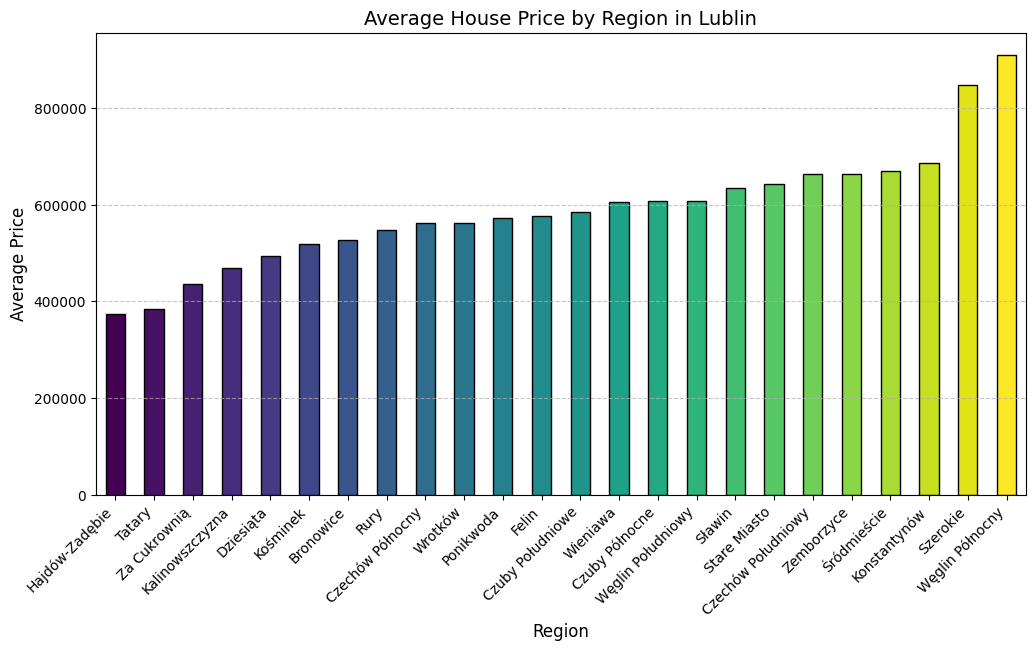

In [29]:
region_avg_price = data.groupby("Region")["Price"].mean().sort_values()

# Generate a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(region_avg_price)))

# Plot the bar chart
plt.figure(figsize=(12, 6))
region_avg_price.plot(kind="bar", color=colors, edgecolor="black")
plt.xlabel("Region", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.title("Average House Price by Region in Lublin", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**Węglin Północny** and **Szerokie** has the highest average house prices, while **Hajdów-Zadębie** has the lowest. The significantly higher average price in **Węglin Północny** and **Szerokie** might be due to the availability of a larger number of apartments in that region. So let's verify it with *pandas*.

In [30]:
filtered_data = data[(data["Region"].isin(["Węglin Północny", "Szerokie"])) & (data["Rooms"] > 4)]
room_count = filtered_data["Region"].value_counts()
display(filtered_data)
    
room_count

,Price,Area,Elevator,Year,Rooms,Floor,Region
393,999000.0,140.0,0.0,2000,5.0,1 piętro,Węglin Północny
2555,2900000.0,298.0,0.0,2003,10.0,1 piętro,Szerokie


Region
Węglin Północny    1
Szerokie           1
Name: count, dtype: int64

The high average prices in Węglin Północny and Szerokie are likely due to the low number of listings and the presence of more expensive, large apartments, which highly increase the average price.

### 3.4 Floor Analysis

Number of unique values for each floor level.

In [31]:
data['Floor'].value_counts()

Floor
3 piętro      563
2 piętro      556
1 piętro      547
parter        495
4 piętro      296
5 piętro      112
6 piętro       73
7 piętro       50
10 piętro      32
9 piętro       31
8 piętro       15
10+ piętro      9
suterena        1
poddasze        1
Name: count, dtype: int64

Similar to `Regions`, the distribution of listings across `Floors` is uneven. Lower **floors (1-4)** have significantly more listings, while higher **floors (8+)** and unique categories like **suterena** and **poddasze** have very few. This imbalance also could affect model accuracy, as it may struggle to predict prices for less common floor types. In the later part of the project, I will outline my approach to address this issue and ensure a more balanced model. 

**Bar chart**: Average price per floor category to determine which floor levels are most expensive.

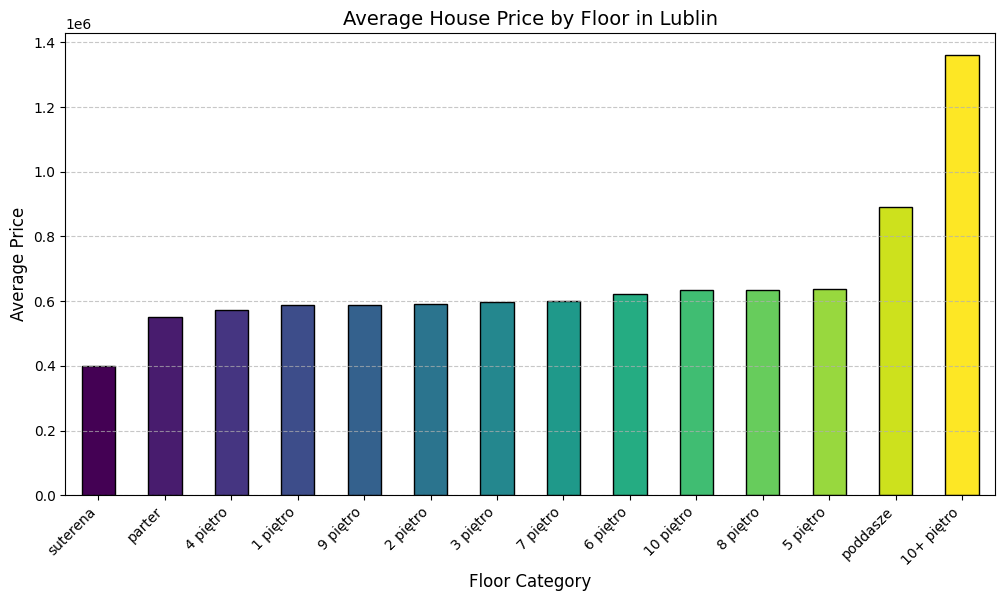

In [32]:
# Group by Floor and calculate the average price
floor_avg_price = data.groupby("Floor")["Price"].mean().sort_values()

# Generate a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(floor_avg_price)))

# Plot the bar chart
plt.figure(figsize=(12, 6))
floor_avg_price.plot(kind="bar", color=colors, edgecolor="black")
plt.xlabel("Floor Category", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.title("Average House Price by Floor in Lublin", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Most floors have relatively stable average prices, but **poddasze** and **10+ piętro** stand out with significantly higher prices. This could be due to penthouse apartments or luxury properties on these floors, in next step we check it. **Suterena** has the lowest average price, likely due to lower demand. Other floar levels have similar average prices, indicating that floor level alone may not be a strong predictor of price.


Let's check the observations where the floor is *poddasze*, *suterena* and *10+ piętro* to verify how they look like.

In [33]:
# Filtering the dataset for the specified floor categories: "poddasze", "suterena", and "10+ piętro"
filtered_floors = data[data["Floor"].isin(["poddasze", "suterena", "10+ piętro"])]
grouped_floors = filtered_floors.groupby("Floor").apply(lambda x: x.head(11)).reset_index(drop=True)
grouped_floors

,Price,Area,Elevator,Year,Rooms,Floor,Region
0,538000.0,41.439999,1.0,2015,2.0,10+ piętro,Rury
1,1499000.0,88.199997,1.0,2019,4.0,10+ piętro,Czechów Południowy
2,1299000.0,81.000000,1.0,2013,3.0,10+ piętro,Rury
3,585000.0,33.330002,1.0,2023,2.0,10+ piętro,Czechów Południowy
4,1450000.0,103.010002,1.0,2023,5.0,10+ piętro,Czechów Południowy
5,1940000.0,314.000000,0.0,2020,10.0,10+ piętro,Wieniawa
6,530000.0,48.200001,1.0,1977,3.0,10+ piętro,Stare Miasto
7,2150000.0,130.000000,1.0,2013,4.0,10+ piętro,Czechów Południowy
8,2250000.0,131.199997,1.0,2020,5.0,10+ piętro,Czechów Południowy
9,890000.0,85.000000,0.0,1911,5.0,poddasze,Dziesiąta


**poddasze** is one old apartment with 5 rooms, which could explain it's high price.\
**suterena** is a 1992-built apartment with 3 rooms and no elevator, likely contributing to its lower price. \
**10+ piętro** show a wide range of prices, likely influenced by area, number of rooms, and location. Large aprtment with 10 rooms and 314 m² area has the highest price, but this is too strange observation, because is too large for 10+ floor. Шt could be a mistake made by the author of the announcement, so I will remove this observation.

In [34]:
data = data.drop(data[(data['Area'] == 314.0) & (data['Floor'] == "10+ piętro")].index)

### 3.5 Temporal Trends

**Scatter plot**: Year vs. Price to see if newer buildings are more expensive.

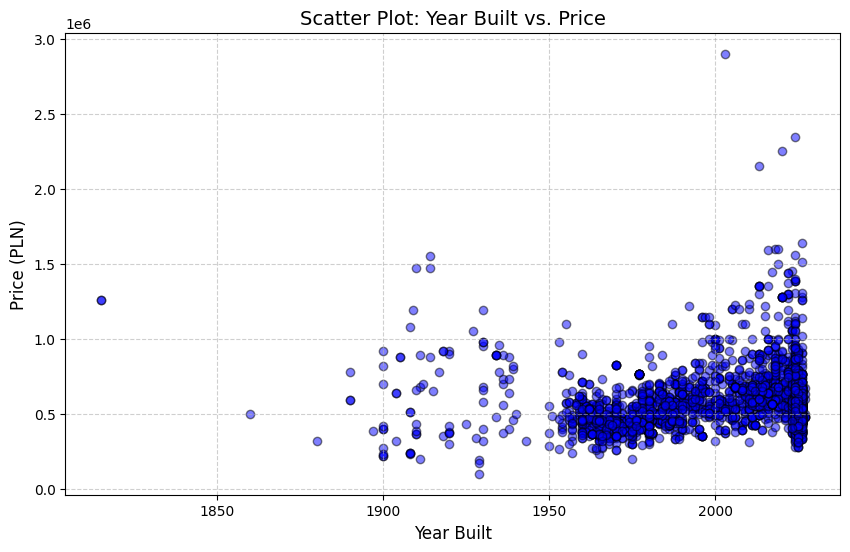

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(data["Year"], data["Price"], alpha=0.5, color="blue", edgecolors="black")

# Labels and title
plt.xlabel("Year Built", fontsize=12)
plt.ylabel("Price (PLN)", fontsize=12)
plt.title("Scatter Plot: Year Built vs. Price", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()

The scatter plot shows a weak relationship between year built and price, meaning newer buildings are not always more expensive. 
- There is one outlier from before 1850, which may be a historic or incorrectly recorded property.
- The 1850-1950 range has very few observations, which could make predictions for older buildings unreliable.
- This imbalance may affect model accuracy, as it will have less data to learn patterns for very old properties.

Additionally, there are three observations with significantly higher prices, which also is necessary to check.

In the later part of the project, I will propose a solution to address this issue and improve model performance. 

### 3.6 Elevator Analysis

- **Bar chart**: Average price comparison for properties with and without elevators.
- **Stacked bar chart**: Number of properties with and without elevators per floor category.

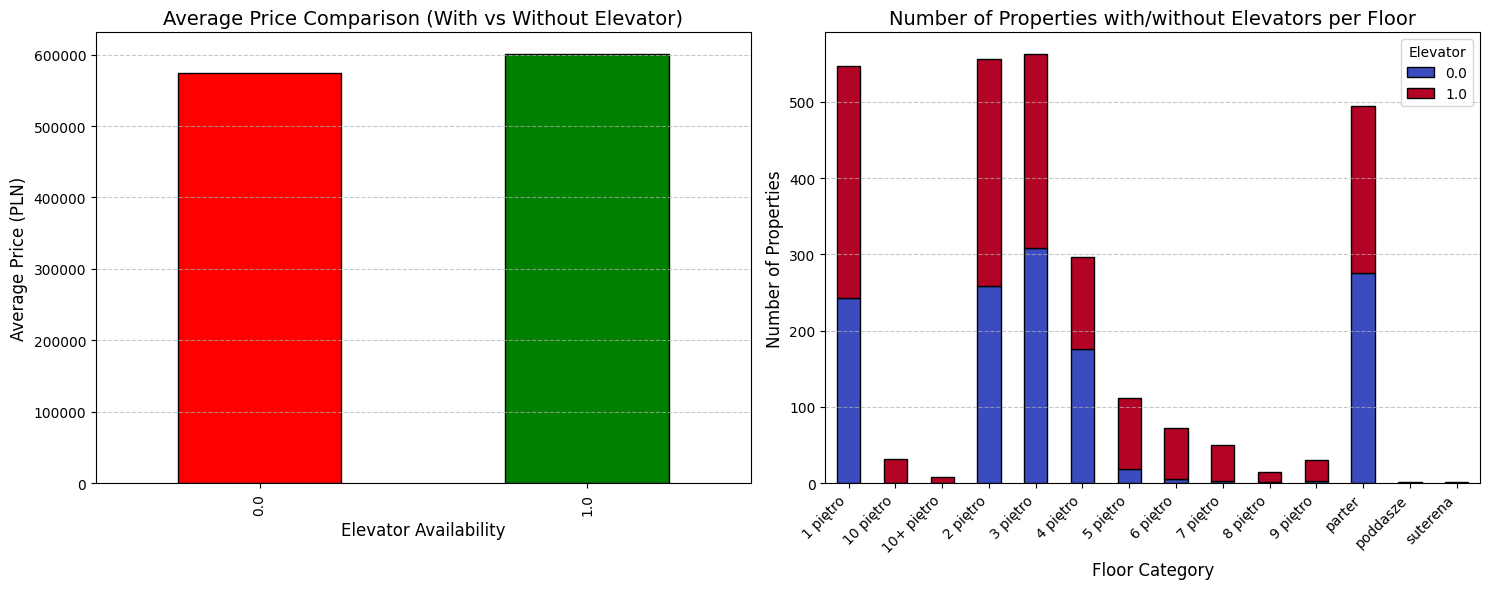

In [36]:
# First plot: Average price comparison for properties with and without elevators
avg_price_elevator = data.groupby("Elevator")["Price"].mean()

# Second plot: Stacked bar chart - Number of properties with and without elevators per floor category
elevator_per_floor = data.groupby(["Floor", "Elevator"]).size().unstack(fill_value=0)

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart: Average price comparison
avg_price_elevator.plot(kind="bar", ax=axes[0], color=["red", "green"], edgecolor="black")
axes[0].set_xlabel("Elevator Availability", fontsize=12)
axes[0].set_ylabel("Average Price (PLN)", fontsize=12)
axes[0].set_title("Average Price Comparison (With vs Without Elevator)", fontsize=14)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Stacked bar chart: Number of properties with and without elevators per floor
elevator_per_floor.plot(kind="bar", stacked=True, ax=axes[1], colormap="coolwarm", edgecolor="black")
axes[1].set_xlabel("Floor Category", fontsize=12)
axes[1].set_ylabel("Number of Properties", fontsize=12)
axes[1].set_title("Number of Properties with/without Elevators per Floor", fontsize=14)
axes[1].legend(title="Elevator", loc="upper right")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-axis labels for better readability
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Show the plots
plt.tight_layout()
plt.show()

As we remember from basic statistics, about 53% of properties have an elevator. The average price for properties with elevators is few higher than for those without, but the difference is not significant. Higher floors buildings mostly have elevators, while in advertisements with lower floors, the presence of an elevator is less common.

### 3.7 Price and Property Characteristics

In this section, I will analyze key property characteristics—price, area, and number of rooms—using box plots. These visualizations help identify the **distribution**, **spread**, and **presence of outliers** in each variable.

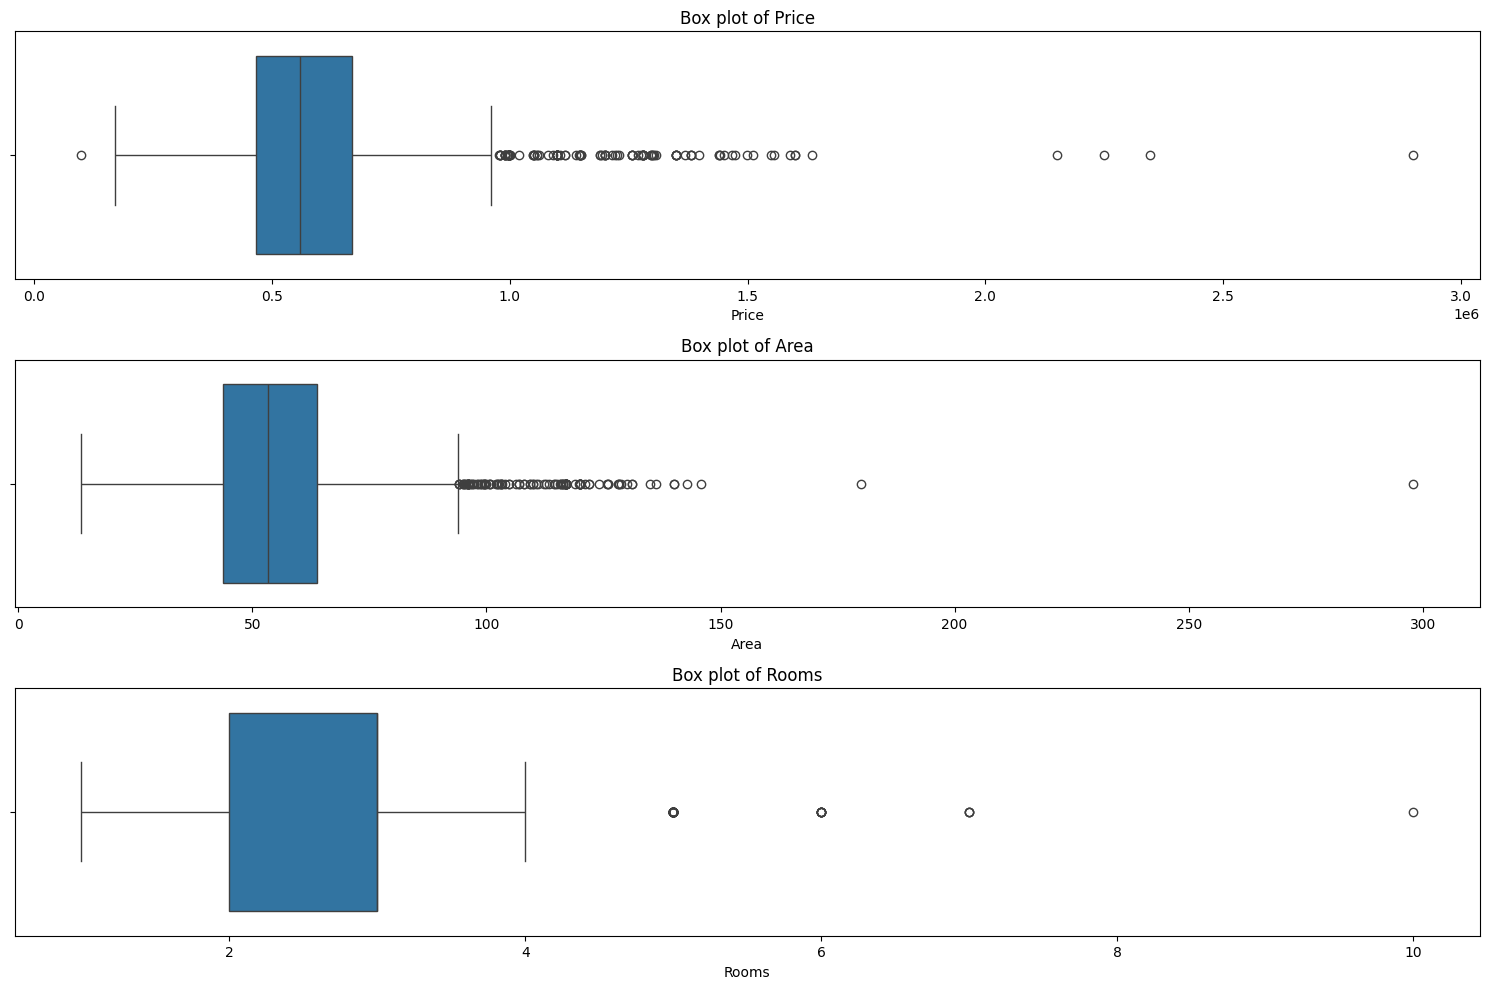

In [37]:
numerical_columns = ['Price', 'Area', 'Rooms']
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x=data[column], orient='h')
    plt.title(f'Box plot of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

**Box Plot of Price**
Most house prices fall within a certain range, with a few outliers extending significantly beyond 1,500,000 PLN. The median price is located in the lower portion of the box, suggesting that most properties are closer to the lower price range.

**Box Plot of Area**
Most house areas are between approximately 30 sqm and 100 sqm.There are several outliers representing houses with exceptionally large areas (over 150 sqm).

**Box Plot of Rooms:**
The majority of listings have 2 to 4 rooms. However, there are several outliers with 5+ rooms.

### 3.8 Analysis Results

Such a broad analysis helped us to familiarize ourselves with the data and understand its concept in more detail. Each step of the analysis revealed strange ads, a lack of relevant types, and outliers in the data. 

- Price and area do not follow a normal distribution, with a right skew indicating 
- Imbalanced number of observations across regions, with some regions having significantly more listings than others.
- Imbalanced floor distribution, with some floors having significantly more listings and a higher average price.
- Outliers in Price, Area, Rooms, and Year, with extreme values that may indicate errors

So in next stage, I will address these issues and prepare the data for modeling.

## 4. Feature Engineering & Transformation

### 4.1 Floor Feature Transformation

Now let's make winsorization of the `Year` column to ensure that winsorization was successful, I make a box plot of the `Year` column before and after winsorization.

In this step, I will clean and transform the `Floor` feature in the next way:
-  Remove rare categories like *suterena* and *poddasze*.
-  **Group higher floors**: Merge all floors 5 and above  into a single `5+ piętro` category to balance the dataset.

In [38]:
# Drop rare categories ("suterena" and "poddasze")
data = data[~data['Floor'].isin(['suterena', 'poddasze'])]

In [39]:
# Merge floors 5 and above into "5+ piętro"
high_floors = ['5 piętro', '6 piętro', '7 piętro', '8 piętro', '9 piętro', '10 piętro', '10+ piętro']
data['Floor'] = data['Floor'].replace(high_floors, '5+ piętro')

Now let's check new distribution to confirm changes

In [40]:
data["Floor"].value_counts()

Floor
3 piętro     563
2 piętro     556
1 piętro     547
parter       495
5+ piętro    321
4 piętro     296
Name: count, dtype: int64

This transformation ensures that all floor categories are *well-represented*, avoiding extreme class imbalance.

### 4.2 Regional Feature Transformation

In this step, I will transform the `Region` feature in the next way:
- Identify low-frequency regions – Regions with less than 50 listings will be grouped into a single `Other` category.
- Replace these regions with `Other`

In [41]:
# Define the threshold for low-frequency regions
threshold = 50  

# Identify low-frequency regions
region_counts = data['Region'].value_counts()
low_freq_regions = region_counts[region_counts < threshold].index

# Replace low-frequency regions with "Other"
data['Region'] = data['Region'].replace(low_freq_regions, 'Other')

In [42]:
data['Region'].value_counts()

Region
Śródmieście           299
Sławin                267
Ponikwoda             238
Wrotków               226
Czechów Północny      211
Czechów Południowy    207
Rury                  204
Węglin Południowy     174
Wieniawa              134
Dziesiąta             110
Kośminek              103
Czuby Północne         92
Kalinowszczyzna        82
Bronowice              81
Other                  81
Stare Miasto           73
Konstantynów           71
Tatary                 64
Felin                  61
Name: count, dtype: int64

This **minimally balances the dataset** by reducing the number of categories and grouping low-frequency regions. However, some regions still have significantly more observations than others. To address this imbalance further, I will **apply weighting during model training** to ensure that less-represented regions contribute proportionally to the learning process.

Before handling outliers, I’ll train a baseline Random Forest model with:
- Region-based weighting for fair learning across all regions.
- `max_features='sqrt'` to reduce overfitting and improve generalization.

In [43]:
# Copy dataset
data_rf3 = data.copy()

# Compute region sample weights
region_counts = data_rf3['Region'].value_counts()
total_count = len(data_rf3)
region_weights = total_count / region_counts

# Map weights to each sample based on its Region
data_rf3['region_weight'] = data_rf3['Region'].map(region_weights)

# One-hot encode categorical variables
data_rf3 = pd.get_dummies(data_rf3, columns=['Floor', 'Region'], drop_first=True)

# Define features and target
features = data_rf3.drop(['Price', 'region_weight'], axis=1)  # Exclude weight from features
target = data_rf3['Price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(
    features, target, data_rf3['region_weight'], test_size=0.2, random_state=42
)

# Initialize and train the Random Forest model with sample weights and regularization
rf_model3 = RandomForestRegressor(
    n_estimators=100,       
    max_features='sqrt',    # Use sqrt(features) per tree (adds randomness)
    random_state=42
)

# Train the model with sample weighting
rf_model3.fit(X_train, y_train, sample_weight=train_weights)

# Predict on test set
y_pred = rf_model3.predict(X_test)

# Evaluate the model
rf3_r2, rf3_mae, rf3_mse, rf3_rmse, rf3_mape, rf3_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {rf3_r2:.4f}")  
print(f"MAE: {rf3_mae:.2f}")  
print(f"RMSE: {rf3_rmse:.2f}") 
print(f"MAPE: {rf3_mape:.2f}") 
print(f"RMSLE: {rf3_rmsle:.4f}") 

R^2: 0.8506
MAE: 43251.54
RMSE: 78972.41
MAPE: 6.99
RMSLE: 0.1126


The baseline model performed better compared to the previous version, showing improvement due to **region-based weighting** and **max_features='sqrt'**. However, there's still room for improvement, especially in reducing errors.

Now, let's focus on handling outliers and feature transformations to further enhance model performance. 

### 4.3 Handling Outliers

#### 4.3.1 Univariate Outlier Detection & Handling

To begin, I use the IQR method to identify outliers in Price, Area, Rooms, and Year.

In [44]:
# Columns to check for outliers
columns_to_check = ['Price', 'Area', 'Rooms', 'Year']

# Dictionary to store outlier counts
outlier_counts = {}

# Detect outliers for each column and count them
for col in columns_to_check:
    outliers = detect_outliers_iqr(data, col)
    outlier_counts[col] = len(outliers)
    print(f"Outliers in {col}: {len(outliers)}")

Outliers in Price: 113
Outliers in Area: 107
Outliers in Rooms: 54
Outliers in Year: 44


IQR method identified such large number of outliers, as I explored in the EDA section this is apartament with very large area and number of rooms and removing them could lead to difficulties of the model to predict real estate of this type, so eliminating is not the best solution. Instead of that I will apply different treatments to each variable:
-  `Year` – Some extreme values likely result from data entry errors. I will apply Winsorization (1%-99%) to cap extreme values while preserving most of the distribution.
- `Price` & `Area` – These variables have a right-skewed distribution. Instead of Winsorization. 
    - Since `Price` is the target variable, I will leave it unchanged, as previous attempts at transformation and standardization resulted in worse metrics after inverse transformation. 
    - For `Area`, I will apply a Box-Cox transformation to normalize its distribution, followed by standardization to ensure consistent scaling.
-  `Rooms` – I have previously analyzed low impact of this variable on model predictions(it is highly correlated with Area), despite this I will standardize it to avoid potential issues with outliers. For tree-based models, I stay it unchanged and apply sample weighting to increase importance of houses with more rooms.

Now let's make winsorization of the `Year` column to ensure that winsorization was successful, I make a box plot of the `Year` column before and after winsorization.

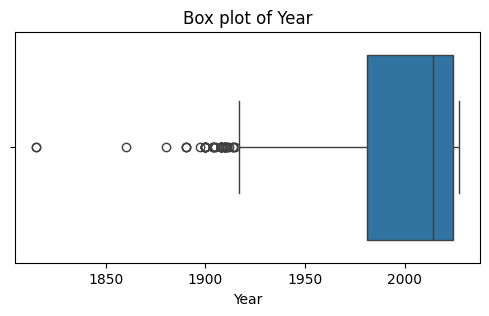

In [45]:
plt.figure(figsize=(6, 3))
sns.boxplot(x=data['Year'])
plt.title('Box plot of Year')
plt.xlabel('Year')
plt.show()

In [46]:
data['Year'] = winsorize_series(data['Year'])

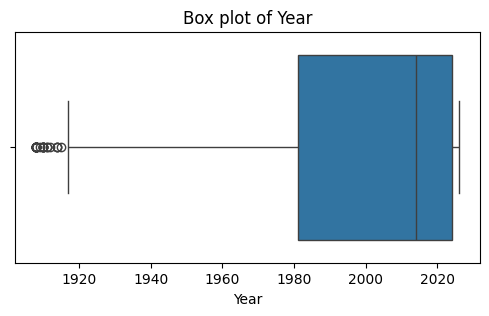

In [47]:
plt.figure(figsize=(6, 3))
sns.boxplot(x=data['Year'])
plt.title('Box plot of Year')
plt.xlabel('Year')
plt.show()


Winsorization was successfully applied – extreme outliers have been controlled. This prevents older outliers from distorting the model without losing meaningful variations.

#### 4.3.2 Multivariate Outlier Detection & Handling

Unlike univariate methods, multivariate outlier detection identifies anomalous combinations of values

For this I will apply `DBSCAN` clustering to identify multivariate outliers in the dataset

Before using DBSCAN, let's choose best `eps` and `min_samples` parameters for the model. To do this, I will use the following discussion from StackOverflow: https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan/15063143#15063143

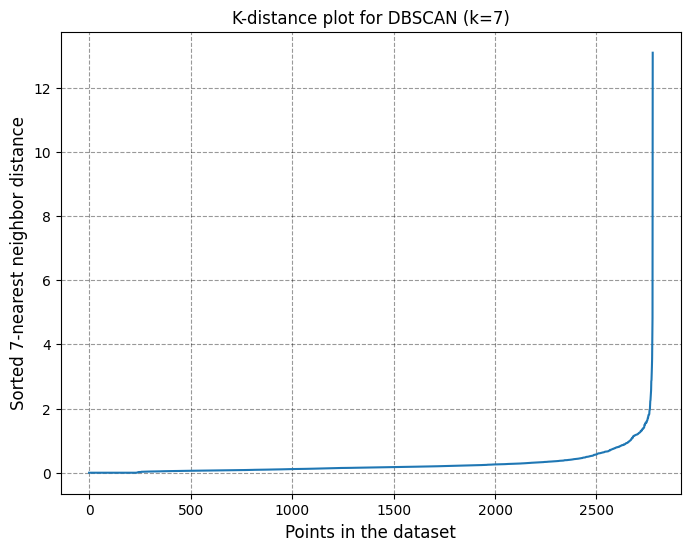

In [48]:
# Create a copy of the dataset
df_dbscan = data.copy()

# Select numerical features for DBSCAN
features_for_dbscan = ['Price', 'Area', 'Rooms', 'Year']

# Standardize the selected features (DBSCAN is sensitive to scale)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_dbscan[features_for_dbscan])

# Compute k-value using formula k = 2 * {dim(dataset)} - 1
k = 2 * scaled_features.shape[1] - 1  # k=2*number_of_features - 1

# Generate k-distance plot
get_kdist_plot(X=scaled_features, k=k)

From the plot, the optimal value for `eps` can be assumed at around 1.5

For `min_samples`, I will use general rule of thumb: `min_samples = 2 * number of features`, so in this case `min_samples = 2 * 4 = 8`

In [49]:
# Apply DBSCAN for outlier detection
dbscan = DBSCAN(eps=1.5, min_samples=8)  
df_dbscan['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_features)

In [50]:
# Count and display number of detected outliers
outlier_count = (df_dbscan['DBSCAN_Cluster'] == -1).sum()
print(f"Total DBSCAN Outliers Detected: {outlier_count}")

Total DBSCAN Outliers Detected: 20


In [51]:
# Display the detected outliers ordered by Year column
outliers_dbscan = df_dbscan[df_dbscan['DBSCAN_Cluster'] == -1].sort_values(by='Year')
print(outliers_dbscan.to_string(index=False))

    Price       Area  Elevator  Year  Rooms     Floor             Region  DBSCAN_Cluster
1080000.0  72.000000       0.0  1908    4.0    parter        Śródmieście              -1
1256810.0  90.459999       0.0  1908    4.0  1 piętro        Śródmieście              -1
1256000.0  90.459999       0.0  1908    4.0  1 piętro        Śródmieście              -1
 428000.0 107.000000       0.0  1910    2.0  1 piętro          Dziesiąta              -1
1468000.0 125.750000       0.0  1910    5.0  2 piętro        Śródmieście              -1
1550000.0 128.800003       0.0  1914    4.0  3 piętro        Śródmieście              -1
1473000.0  98.199997       0.0  1914    4.0  1 piętro        Śródmieście              -1
 920000.0 140.000000       0.0  1918    5.0  4 piętro        Śródmieście              -1
 920000.0 126.000000       0.0  1918    7.0  4 piętro        Śródmieście              -1
1049000.0 126.000000       0.0  1927    4.0  1 piętro        Śródmieście              -1
 190237.5  71.339996 

After analyzing the DBSCAN outliers, I identified the following key patterns:
- Mostly very old houses - These properties have been previously Winsorized, but their characteristics still deviate significantly from typical listings.
- Some houses with extremely high price per square meter
- One apartment

**Why Remove These Outliers?**
-  Small number of cases (only 20)
-  Synthetic filling (e.g., SMOGN) could introduce misleading data
-  Retaining them could bias the model

Since these outliers are few in number, highly unrepresentative, and potentially misleading, the best approach is to remove them from the dataset rather than attempting to fix or synthesize new observations.

So delete that outliers from the main dataset.

In [52]:
# Identify outliers (DBSCAN-flagged as -1)
outlier_indices = df_dbscan[df_dbscan['DBSCAN_Cluster'] == -1].index

# Remove outliers from the main dataset
data = data.drop(index=outlier_indices)

Save cleaned dataset to the file

In [53]:
data.to_csv('data/houses_data_cleaned.csv', index=False)

### 4.4 Box-Cox Transformation and Standardization

❗❗❗ **Important Note** ❗❗❗

As I will build multiple machine learning models, some require data transformation and standardization, while others do not.
- Linear models & Neural Networks: Require raw Price, Box-Cox transformation Area and standardization for numerical features.
- Tree-based models (Random Forest, XGBoost, etc.): Work best with raw Price, Box-Cox transformed Area, and unstandardized features.

To streamline the process, I will create a new dataset with standardized data for models that need it while keeping the original values for tree-based models.

In [54]:
data_tree = data.copy()
data_standardized = data.copy()

Firstly I will prepare data for linear models and neural networks by applying Box-Cox transformation and standardization to numerical features.

Apply the Box-Cox transformation to the `Area` column to make it more normally distributed. `Area` doesn't have non-positive values, so I can apply the Box-Cox transformation without any issues. And after that, I will standardize all numerical features, apart from `Elevator`, which is binary.

In [55]:
# Apply Box-Cox only to `Area` 
data_standardized['Area'], lambda_area = boxcox(data_standardized['Area'])

# Standardize numerical features 
scaler = StandardScaler()
data_standardized[['Area', 'Rooms', 'Year']] = scaler.fit_transform(
    data_standardized[['Area', 'Rooms', 'Year']]
)

# One-hot encode categorical variables
data_standardized = pd.get_dummies(data_standardized, columns=['Floor', 'Region'], drop_first=True, dtype=int)

# Save the scaler and lambda values
joblib.dump(scaler, "scaler.pkl")  
lambda_values = {'Area': lambda_area}  # No transformation for `Price`

# Check transformation effect
print(f"Box-Cox Lambda for Area: {lambda_area}")

Box-Cox Lambda for Area: 0.06311980250720337


- Lambda for `Area`: `0.063`
    - This is close to 0, but slightly positive.
    - It means the transformation is mildly different from a log transformation but still effective in reducing skewness.

In [56]:
data_standardized.head()

,Price,Area,Elevator,Year,Rooms,Floor_2 piętro,Floor_3 piętro,Floor_4 piętro,Floor_5+ piętro,Floor_parter,...,Region_Other,Region_Ponikwoda,Region_Rury,Region_Stare Miasto,Region_Sławin,Region_Tatary,Region_Wieniawa,Region_Wrotków,Region_Węglin Południowy,Region_Śródmieście
0,567000.0,-0.006381,0.0,0.538660,1.572951,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,728500.0,1.286637,1.0,0.842096,1.572951,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,668360.0,0.858723,1.0,0.880026,1.572951,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,833414.0,1.241249,1.0,0.766237,1.572951,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,696500.0,1.376572,1.0,0.842096,1.572951,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now prepare dataset for tree-based models

In [57]:
data_tree['Area'], lambda_area = boxcox(data_tree['Area'])

Since some tree-based algorithms, such as **Random Forest and Decision Trees**, perform better with ordinal encoding, while boosting algorithms like XGBoost and LightGBM tend to work better with one-hot encoding, I will apply the appropriate encoding method to categorical features before training each model.

In [58]:
data_tree.head()

,Price,Area,Elevator,Year,Rooms,Floor,Region
0,567000.0,4.499900,0.0,2017,4.0,3 piętro,Rury
1,728500.0,5.006183,1.0,2025,4.0,3 piętro,Czechów Północny
2,668360.0,4.838632,1.0,2026,4.0,2 piętro,Wrotków
3,833414.0,4.988411,1.0,2023,4.0,1 piętro,Czechów Południowy
4,696500.0,5.041397,1.0,2025,4.0,3 piętro,Kośminek


Let's also build simple RandomForest model on tree based models dataset to check if the results are better.

In [59]:
# Copy dataset
data_rf4 = data_tree.copy()

# Compute region sample weights
region_counts = data_rf4['Region'].value_counts()
total_count = len(data_rf4)
region_weights = total_count / region_counts

# Map weights to each sample based on its Region
data_rf4['region_weight'] = data_rf4['Region'].map(region_weights)

# One-hot encode categorical variables
data_rf4 = pd.get_dummies(data_rf4, columns=['Floor', 'Region'], drop_first=True)

# Define features and target
features = data_rf4.drop(['Price', 'region_weight'], axis=1)  # Exclude weight from features
target = data_rf4['Price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(
    features, target, data_rf4['region_weight'], test_size=0.2, random_state=42
)

# Initialize and train the Random Forest model with sample weights and regularization
rf_model4 = RandomForestRegressor(
    n_estimators=100,       
    max_features='sqrt',    # Use sqrt(features) per tree (adds randomness)
    random_state=42
)

# Train the model with sample weighting
rf_model4.fit(X_train, y_train, sample_weight=train_weights)

# Predict on test set
y_pred = rf_model4.predict(X_test)

# Evaluate the model
rf3_r2, rf3_mae, rf3_mse, rf3_rmse, rf3_mape, rf3_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {rf3_r2:.4f}")  
print(f"MAE: {rf3_mae:.2f}")  
print(f"RMSE: {rf3_rmse:.2f}") 
print(f"MAPE: {rf3_mape:.2f}") 
print(f"RMSLE: {rf3_rmsle:.4f}") 

R^2: 0.8625
MAE: 41888.58
RMSE: 71342.50
MAPE: 7.33
RMSLE: 0.1125


After transformation of the `Area` column rf model achieved better results than before, with an $R^2$ score of 86.5%. The **MAE** of 41888.58 and **RMSE** of 71342.50. **MAPE** increased to 7.33% from 6.99% in the previous model, but it is still a good result. **RMSLE** changed not significantly.

Since the data is now prepared, we can begin experimenting with different machine learning models and optimizing hyperparameters to select the best-performing model.

## 5. Build Machine Learning Models

### 5.1 Linear Regression

In [60]:
# Extract features and target
X = data_standardized.drop(columns=['Price'])  
y = data_standardized['Price'] 

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred = lr_model.predict(X_test)

# Evaluate the model
lr_r2, lr_mae, lr_mse, lr_rmse, lr_mape, lr_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {lr_r2:.4f}")
print(f"MAE: {lr_mae:.2f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"MAPE: {lr_mape:.2f}")
print(f"RMSLE: {lr_rmsle:.4f}")

R^2: 0.7081
MAE: 69721.24
RMSE: 103943.41
MAPE: 11.97
RMSLE: 0.1684


Linear regression performed poorly due to the complex, non-linear relationships in the housing data, which it couldn't capture effectively.

### 5.2 Elastic Net Regression

Elastic Net improves upon Linear Regression by combining L1 (Lasso) and L2 (Ridge) regularization, which helps reduce overfitting, handle multicollinearity, and select important features.

Since its performance depends on alpha (regularization strength) and l1_ratio (balance between L1 and L2), I use GridSearchCV to find the best combination. 

In [ ]:
# Define a broader hyperparameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100],  
    'l1_ratio': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1],
    'max_iter': [5000, 10000, 20000] 
}

# Initialize Elastic Net model
elastic_net = ElasticNet()

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_elastic_net_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best Elastic Net Parameters:", best_params)

# Predict on test data
y_pred = best_elastic_net_model.predict(X_test)

# Evaluate the model
elastic_r2, elastic_mae, elastic_mse, elastic_rmse, elastic_mape, elastic_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {elastic_r2:.4f}")
print(f"MAE: {elastic_mae:.2f}")
print(f"RMSE: {elastic_rmse:.2f}")
print(f"MAPE: {elastic_mape:.2f}")
print(f"RMSLE: {elastic_rmsle:.4f}")

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Elastic Net Parameters: {'alpha': 0.1, 'l1_ratio': 0.7, 'max_iter': 5000}
R^2: 0.6935
MAE: 70146.99
RMSE: 106518.13
MAPE: 11.83
RMSLE: 0.1616


**Elastic Net regression** performed worse than expected, likely due to the non-linear relationships in the data that it couldn't fully capture. So let's try more complex models.

### 5.3 Support Vector Regression

Now let's try **Support Vector Regression (SVR)**, which can capture complex relationships in the data and handle non-linear patterns.

In [ ]:
# Define hyperparameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'epsilon': [0.1, 0.2, 0.5, 0.3]
}

# Initialize SVR model
svr = SVR()

# Perform Grid Search with Cross-Validation 
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_svr_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best SVR Parameters:", best_params)

# Predict on test data
y_pred = best_svr_model.predict(X_test)

# Evaluate the model
svr_r2, svr_mae, svr_mse, svr_rmse, svr_mape, svr_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {svr_r2:.4f}")
print(f"MAE: {svr_mae:.2f}")
print(f"RMSE: {svr_rmse:.2f}")
print(f"MAPE: {svr_mape:.2f}")
print(f"RMSLE: {svr_rmsle:.4f}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best SVR Parameters: {'C': 1000, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
R^2: 0.6348
MAE: 69616.68
RMSE: 116273.44
MAPE: 11.15
RMSLE: 0.1595


**Support Vector Regression (SVR)** performed worse than **Linear and Elastic Net Regression**, struggling to capture the complex relationships in the data. So, let's try tree-based models to better handle non-linearity and feature interactions.

### 5.4 Decision Tree Regressor

I will train a **Decision Tree Regressor** while improving model fairness by applying sample weighting to Region, Floor, and Rooms. Then, I will tune hyperparameters using GridSearchCV for better performance. 

In [64]:
# Label encode categorical features 
label_encoder_floor = LabelEncoder()
label_encoder_region = LabelEncoder()

data_tree['Floor'] = label_encoder_floor.fit_transform(data_tree['Floor'])
data_tree['Region'] = label_encoder_region.fit_transform(data_tree['Region'])

# Compute weights for Region, Floor, and Rooms
region_weights = compute_weights(data_tree, 'Region')
floor_weights = compute_weights(data_tree, 'Floor')
room_weights = compute_weights(data_tree, 'Rooms') 

# Map weights to each sample
data_tree['region_weight'] = data_tree['Region'].map(region_weights)
data_tree['floor_weight'] = data_tree['Floor'].map(floor_weights)
data_tree['room_weight'] = data_tree['Rooms'].map(room_weights)

# Combine weights (average or product method)
data_tree['sample_weight'] = (data_tree['region_weight'] + data_tree['floor_weight'] + data_tree['room_weight']) / 3  # Averaging method

# Define features and target
features = data_tree.drop(columns=['Price', 'region_weight', 'floor_weight', 'room_weight', 'sample_weight'])  # Exclude weight columns
target = data_tree['Price']

# Split data with weights
X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(
    features, target, data_tree['sample_weight'], test_size=0.2, random_state=42
)

In [ ]:
# Expanded hyperparameter grid for better optimization
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 
    'splitter': ['best', 'random'], 
    'max_depth': [5, 10, 15, 20, None],  
    'min_samples_split': [2, 5, 10, 20],  
    'min_samples_leaf': [1, 2, 5, 10], 
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05], 
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1] 
}

# Initialize Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(dt_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train, sample_weight=train_weights) 

# Get the best model and parameters
best_dt_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best Decision Tree Parameters:", best_params)

# Predict on test data
y_pred = best_dt_model.predict(X_test)
# Evaluate the model
dt_r2, dt_mae, dt_mse, dt_rmse, dt_mape, dt_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {dt_r2:.4f}")
print(f"MAE: {dt_mae:.2f}")
print(f"RMSE: {dt_rmse:.2f}")
print(f"MAPE: {dt_mape:.2f}")
print(f"RMSLE: {dt_rmsle:.4f}")

Fitting 5 folds for each of 23040 candidates, totalling 115200 fits
Best Decision Tree Parameters: {'ccp_alpha': 0.0, 'criterion': 'poisson', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
R^2: 0.7292
MAE: 52319.71
RMSE: 100119.68
MAPE: 8.89
RMSLE: 0.1474


The **Decision Tree Regressor** performed better than previous models, but there is still room for improvement. To achieve higher accuracy, I will now try more advanced models like Random Forest and Boosting algorithms

### 5.5 Random Forest Regressor

Now, I build again a **Random Forest Regressor**, with weighted samples and hyperparameter tuning to improve performance.

In [ ]:
# Expanded hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500], 
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5], 
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False] 
}

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Grid Search with Cross-Validation 
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train, sample_weight=train_weights) 

# Get the best model and parameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best Random Forest Parameters:", best_params)

# Predict on test data
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
rf_r2, rf_mae, rf_mse, rf_rmse, rf_mape, rf_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {rf_r2:.4f}")
print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAPE: {rf_mape:.2f}")
print(f"RMSLE: {rf_rmsle:.4f}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
R^2: 0.8598
MAE: 39927.44
RMSE: 72041.99
MAPE: 6.86
RMSLE: 0.1100


Compared to the previous Random Forest model, the new model showed a lower $R^2$ but improved **MAE**, **MAPE**, and **RMSLE**, indicating overall better prediction accuracy. However, the higher **RMSE** suggests the presence of a few large errors, likely due to some extreme incorrect predictions.

Now, I will build boosting algorithms, which can handle complex relationships, reduce bias, and improve accuracy by combining multiple weak models into a strong one. 

### 5.6 Gradient Boosting Regressor

Prepare data for boosting algorithms by one-hot encoding categorical features and train/test split.

In [67]:
# One-hot encode categorical features
data_boosting = pd.get_dummies(data_tree, columns=['Floor', 'Region'], drop_first=True, dtype=int)

# Define features and target
X = data_boosting.drop(columns=['Price'])
y = data_boosting['Price']  

# Split data (without sample weights)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I will train a **Gradient Boosting Regressor (GBR)** using one-hot encoding for categorical features (`Floor`, `Region`) because GBR does not natively handle categorical variables. One-hot encoding allows the model to learn without assuming ordinal relationships. Then, I will optimize hyperparameters using GridSearchCV to improve performance.

In [68]:
# Define a lighter hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 300],  
    'learning_rate': [0.01, 0.1], 
    'max_depth': [3, 7],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'subsample': [0.7, 1.0],  
    'max_features': ['sqrt', None] 
}

# Initialize Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)  

# Get the best model and parameters
best_gbr_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best GBR Parameters:", best_params)

# Predict on test data
y_pred = best_gbr_model.predict(X_test)

# Evaluate the model
gbr_r2, gbr_mae, gbr_mse, gbr_rmse, gbr_mape, gbr_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {gbr_r2:.4f}")
print(f"MAE: {gbr_mae:.2f}")
print(f"RMSE: {gbr_rmse:.2f}")
print(f"MAPE: {gbr_mape:.2f}")
print(f"RMSLE: {gbr_rmsle:.4f}")

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best GBR Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.7}
R^2: 0.8530
MAE: 40550.43
RMSE: 73777.39
MAPE: 6.98
RMSLE: 0.1137


The Gradient Boosting Regressor (GBR) without sample weighting showed slightly worse results compared to the Random Forest model. 

### 5.7 XGBoost Regressor

In [69]:
# Define a lighter hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 300], 
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 7], 
    'min_child_weight': [1, 5],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.7, 1.0], 
    'gamma': [0, 0.1],  
    'reg_alpha': [0, 0.1], 
    'reg_lambda': [1, 10] 
}

# Initialize XGBoost Regressor
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform Grid Search with Cross-Validation 
grid_search = GridSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_xgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best XGBoost Parameters:", best_params)

# Predict on test data
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
xgb_r2, xgb_mae, xgb_mse, xgb_rmse, xgb_mape, xgb_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {xgb_r2:.4f}")
print(f"MAE: {xgb_mae:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"MAPE: {xgb_mape:.2f}")
print(f"RMSLE: {xgb_rmsle:.4f}")

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best XGBoost Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7}
R^2: 0.8533
MAE: 41494.26
RMSE: 73683.25
MAPE: 7.10
RMSLE: 0.1124


XGBoost showed similar results to the Gradient Boosting Regressor, with a slightly lower $R^2$ score. Now additionally let's try LightGBM.

### 5.8 LightGBM Regressor

LightGBM more often used for large datasets, but instead of that I will try it on this dataset to check if it will perform better than previous models.

In [70]:
# Define a hyperparameter grid
param_grid = {
    'n_estimators': [100, 300],  
    'learning_rate': [0.05, 0.1],  
    'max_depth': [5, 10], 
    'num_leaves': [20, 31, 50],
    'min_child_samples': [10, 20],
    'subsample': [0.8, 1.0], 
    'colsample_bytree': [0.8, 1.0]
}

# Initialize LightGBM Regressor with logging disabled
lgb_regressor = lgb.LGBMRegressor(random_state=42, verbose=-1)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(lgb_regressor, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

# Restore stderr to normal
sys.stderr = sys.__stderr__

# Get the best model and parameters
best_lgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best LightGBM Parameters:", best_params)

# Predict on test data
y_pred = best_lgb_model.predict(X_test)

# Evaluate the model
lgb_r2, lgb_mae, lgb_mse, lgb_rmse, lgb_mape, lgb_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {lgb_r2:.4f}")
print(f"MAE: {lgb_mae:.2f}")
print(f"RMSE: {lgb_rmse:.2f}")
print(f"MAPE: {lgb_mape:.2f}")
print(f"RMSLE: {lgb_rmsle:.4f}")

  File "c:\Users\davyd\miniconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\davyd\miniconda3\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\davyd\miniconda3\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\davyd\miniconda3\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Best LightGBM Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 50, 'subsample': 0.8}
R^2: 0.8505
MAE: 43372.12
RMSE: 74393.43
MAPE: 7.47
RMSLE: 0.1160


### 5.9 CatBoost Regressor

**CatBoost** is different from **LightGBM** and **XGBoost** because it natively supports categorical features, so there is no need to one-hot encode them. 

In [71]:
# Define categorical features 
cat_features = ['Floor', 'Region']

# Define features and target
X = data_tree.drop(columns=['Price']) 
y = data_tree['Price']  

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a hyperparameter grid for CatBoost
param_grid = {
    'iterations': [1000], # [500, 1000,]
    'learning_rate': [0.1], # [0.05, 0.1]
    'depth': [6], # [6, 10]
    'l2_leaf_reg': [3], # [3, 10]
    'bagging_temperature': [0.5], # [0.5, 1.0]
    'random_strength': [1]  # [1, 5]
}

# Initialize CatBoost Regressor with categorical feature support
catboost_regressor = CatBoostRegressor(cat_features=cat_features, random_state=42, verbose=0)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(catboost_regressor, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

# Restore stderr to normal
sys.stderr = sys.__stderr__

# Get the best model and parameters
best_catboost_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters
print("Best CatBoost Parameters:", best_params)

# Predict on test data
y_pred = best_catboost_model.predict(X_test)

# Evaluate the model
catboost_r2, catboost_mae, catboost_mse, catboost_rmse, catboost_mape, catboost_rmsle = evaluate_model(y_test, y_pred)

# Print results
print(f"R^2: {catboost_r2:.4f}")
print(f"MAE: {catboost_mae:.2f}")
print(f"RMSE: {catboost_rmse:.2f}")
print(f"MAPE: {catboost_mape:.2f}")
print(f"RMSLE: {catboost_rmsle:.4f}")

Best CatBoost Parameters: {'bagging_temperature': 0.5, 'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'random_strength': 1}
R^2: 0.8493
MAE: 46745.21
RMSE: 74690.54
MAPE: 8.00
RMSLE: 0.1136


**CatBoost** did not perform as well as expected, showing slightly worse results compared to other boosting algorithms (**Gradient Boosting** ,**XGBoost**, **LightGBM**) and **Random Forest**.

### 5.10 Model Comparison

Finally let's compare all models to choose which showed the best results.

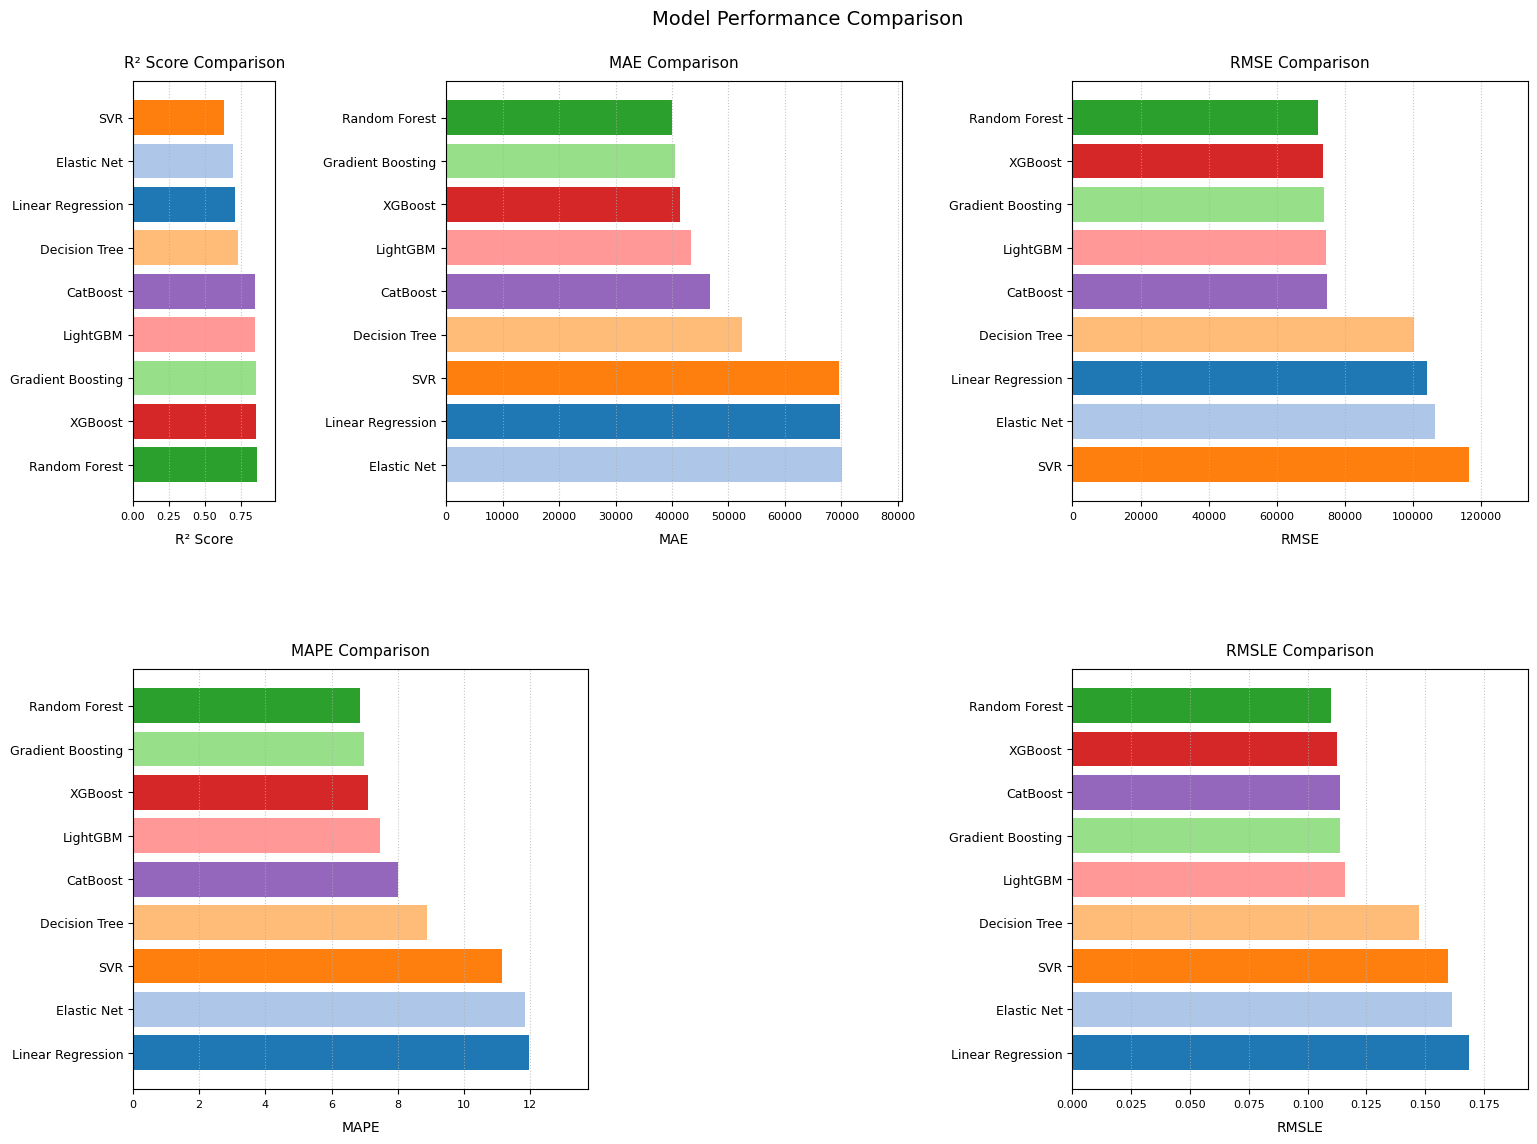

In [115]:
# Define metric values for each model
r2_scores = {
    "Linear Regression": lr_r2,
    "Elastic Net": elastic_r2,
    "SVR": svr_r2,
    "Decision Tree": dt_r2,
    "Random Forest": rf_r2,
    "Gradient Boosting": gbr_r2,
    "XGBoost": xgb_r2,
    "LightGBM": lgb_r2,
    "CatBoost": catboost_r2
}

mae_scores = {
    "Linear Regression": lr_mae,
    "Elastic Net": elastic_mae,
    "SVR": svr_mae,
    "Decision Tree": dt_mae,
    "Random Forest": rf_mae,
    "Gradient Boosting": gbr_mae,
    "XGBoost": xgb_mae,
    "LightGBM": lgb_mae,
    "CatBoost": catboost_mae
}

rmse_scores = {
    "Linear Regression": lr_rmse,
    "Elastic Net": elastic_rmse,
    "SVR": svr_rmse,
    "Decision Tree": dt_rmse,
    "Random Forest": rf_rmse,
    "Gradient Boosting": gbr_rmse,
    "XGBoost": xgb_rmse,
    "LightGBM": lgb_rmse,
    "CatBoost": catboost_rmse
}

mape_scores = {
    "Linear Regression": lr_mape,
    "Elastic Net": elastic_mape,
    "SVR": svr_mape,
    "Decision Tree": dt_mape,
    "Random Forest": rf_mape,
    "Gradient Boosting": gbr_mape,
    "XGBoost": xgb_mape,
    "LightGBM": lgb_mape,
    "CatBoost": catboost_mape
}

rmsle_scores = {
    "Linear Regression": lr_rmsle,
    "Elastic Net": elastic_rmsle,
    "SVR": svr_rmsle,
    "Decision Tree": dt_rmsle,
    "Random Forest": rf_rmsle,
    "Gradient Boosting": gbr_rmsle,
    "XGBoost": xgb_rmsle,
    "LightGBM": lgb_rmsle,
    "CatBoost": catboost_rmsle
}

# Create figure with enhanced GridSpec configuration
fig = plt.figure(figsize=(18, 12)) 
gs = gridspec.GridSpec(2, 5, width_ratios=[1,1,1,1,1], wspace=1.2, hspace=0.4)

# Top row assignments
ax0 = plt.subplot(gs[0, 0])  
ax1 = plt.subplot(gs[0, 1:3])  
ax2 = plt.subplot(gs[0, 3:5])   

# Bottom row - centered plots
ax3 = plt.subplot(gs[1, 0:2])  
ax4 = plt.subplot(gs[1, 3:5]) 

# Configure all axes
for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='y', labelsize=9)  # Smaller y-axis labels
    ax.xaxis.set_tick_params(labelsize=8)  # Smaller x-axis labels

# Plotting function with label adjustments
def plot_metric(ax, metric_name, metric_values):
    sorted_metrics = dict(sorted(metric_values.items(), 
                               key=lambda item: item[1], 
                               reverse=True))
    colors = [model_colors[model] for model in sorted_metrics.keys()]
    
    bars = ax.barh(list(sorted_metrics.keys()), 
                 list(sorted_metrics.values()), 
                 color=colors)
    
    ax.set_title(f"{metric_name} Comparison", fontsize=11, pad=10)
    ax.set_xlabel(metric_name, fontsize=10, labelpad=8)
    ax.grid(axis='x', linestyle=':', alpha=0.7)
    
    # Set dynamic x-lim padding
    xmax = max(metric_values.values())
    ax.set_xlim(left=0, right=xmax * 1.15)  # Add 15% padding

# Plot all metrics
metrics_data = [
    (ax0, "R² Score", r2_scores),
    (ax1, "MAE", mae_scores),
    (ax2, "RMSE", rmse_scores),
    (ax3, "MAPE", mape_scores),
    (ax4, "RMSLE", rmsle_scores)
]

for ax, name, values in metrics_data:
    plot_metric(ax, name, values)

# Final layout adjustments
plt.subplots_adjust(top=0.92, bottom=0.08)
plt.suptitle("Model Performance Comparison", fontsize=14)
plt.show()

Among all tested models, **Random Forest** demonstrated the best overall performance across all metrics, making it the most effective model for predicting house prices. Following **Random Forest**, **Gradient Boosting** and **XGBoost** delivered comparable results, performing well but slightly behind. Now, let's try **deep learning models**, to see if they can further improve predictions. 

Use the Interquartile Range (IQR) Method to detect and see the anomalies in the data.

In [166]:
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

price_outliers = find_outliers_iqr(data, 'Price')
area_outliers = find_outliers_iqr(data, 'Area')
room_outliers = find_outliers_iqr(data, 'Rooms')

all_outliers = pd.concat([price_outliers, area_outliers, room_outliers]).drop_duplicates()
all_outliers.head(20)

,Price,Area,Elevator,Rooms,Floor,Region,Year_interval,Year,Price_per_sqm,Outlier_DBSCAN
168,1350000.0,117.000000,1,4,2 piętro,Stare Miasto,2001-2016,2013,11538.461914,0
170,1599000.0,116.879997,1,5,6 piętro,Konstantynów,2016<,2018,13680.698242,0
203,1499000.0,88.199997,1,4,10 piętro,Czechów Południowy,2016<,2019,16995.464844,0
217,1080000.0,72.000000,0,4,parter,Śródmieście,1891-1920,1908,15000.000000,0
233,1299000.0,81.000000,1,3,10 piętro,Rury,2001-2016,2013,16037.037109,0
330,1099500.0,82.570000,1,4,3 piętro,Wrotków,2016<,<NA>,13315.974609,0
337,99000.0,19.000000,0,1,parter,Dziesiąta,1951-1980,<NA>,5210.526367,0
347,1050000.0,77.000000,0,3,1 piętro,Sławin,2016<,2023,13636.363281,0
356,1280000.0,92.000000,0,4,1 piętro,Sławin,2016<,2020,13913.043945,0
390,1149990.0,91.989998,0,4,1 piętro,Sławin,2016<,2019,12501.250000,0


In [167]:
len(all_outliers)

160

IQR method detected very large number of annomalies in the data, so we will not remove them, because they are not errors in the data, but just outliers, because there are some very expensive houses in Lublin.

Use DBSCAN to detect anomalies in the data.

In [190]:
numeric_data = data[['Price', 'Area', 'Rooms']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)
dbscan = DBSCAN(eps=1.5, min_samples=5)
data['Outlier_DBSCAN'] = dbscan.fit_predict(scaled_data)
dbscan_outliers = data[data['Outlier_DBSCAN'] == -1]
dbscan_outliers.head(15)

,Price,Area,Elevator,Rooms,Floor,Region,Year_interval,Year,Price_per_sqm,Outlier_DBSCAN
210,499000.0,128.000000,0,4,4 piętro,Tatary,1951-1980,1960,3898.437500,-1
800,1940000.0,314.000000,0,10,3 piętro,Wieniawa,1951-1980,<NA>,6178.343750,-1
1136,950000.0,90.830002,0,7,4 piętro,Śródmieście,1921-1950,1930,10459.099609,-1
2552,2150000.0,130.000000,1,4,10 piętro,Czechów Południowy,2001-2016,2013,16538.460938,-1
2643,2347058.0,145.779999,1,4,7 piętro,Śródmieście,2016<,2024,16100.000000,-1
2866,475000.0,124.000000,0,5,1 piętro,Kośminek,1981-2001,1980,3830.645264,-1
2937,2900000.0,298.000000,0,10,1 piętro,Szerokie,2001-2016,2003,9731.543945,-1
3056,999000.0,180.000000,0,5,3 piętro,Czechów Północny,1981-2001,1998,5550.000000,-1
3098,2250000.0,131.199997,1,5,10 piętro,Czechów Południowy,2016<,2020,17149.390625,-1


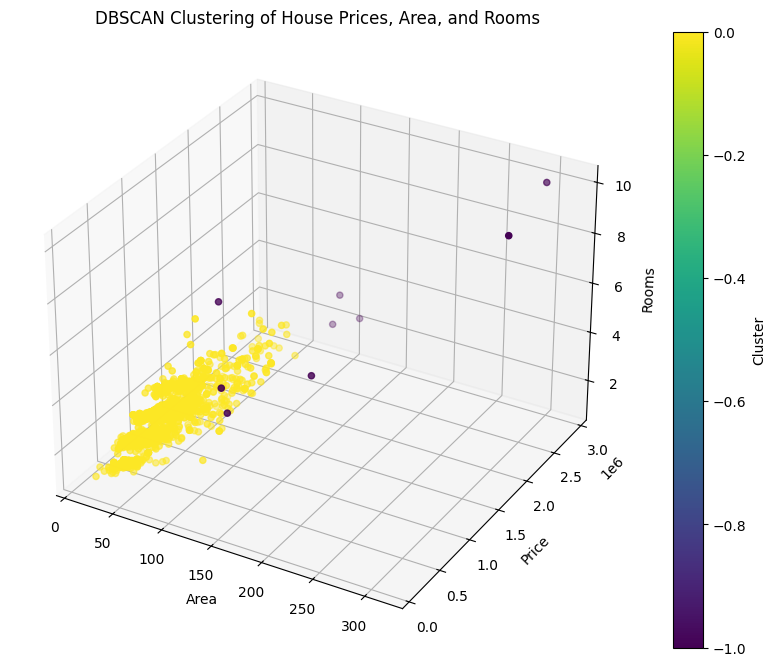

In [191]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data['Area'], data['Price'], data['Rooms'], c=data['Outlier_DBSCAN'], cmap='viridis', marker='o')
ax.set_xlabel('Area')
ax.set_ylabel('Price')
ax.set_zlabel('Rooms')
ax.set_title('DBSCAN Clustering of House Prices, Area, and Rooms')
fig.colorbar(scatter, label='Cluster')
plt.show()

DBSCAN detected 9 anomalies what is much better than IQR method, but if look at that data we can see that with them is everythink ok, so we will not remove them.

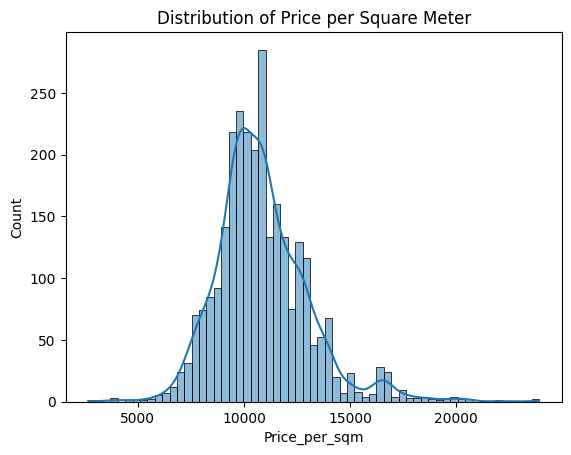

In [149]:
data.loc[:, 'Price_per_sqm'] = data['Price'] / data['Area']
sns.histplot(data=data, x='Price_per_sqm', kde=True)
plt.title('Distribution of Price per Square Meter')
plt.show()

The distribution is unimodal, with a clear peak around 10,000 PLN per square meter. This suggests that the majority of houses in Lublin have a price per square meter near this value.

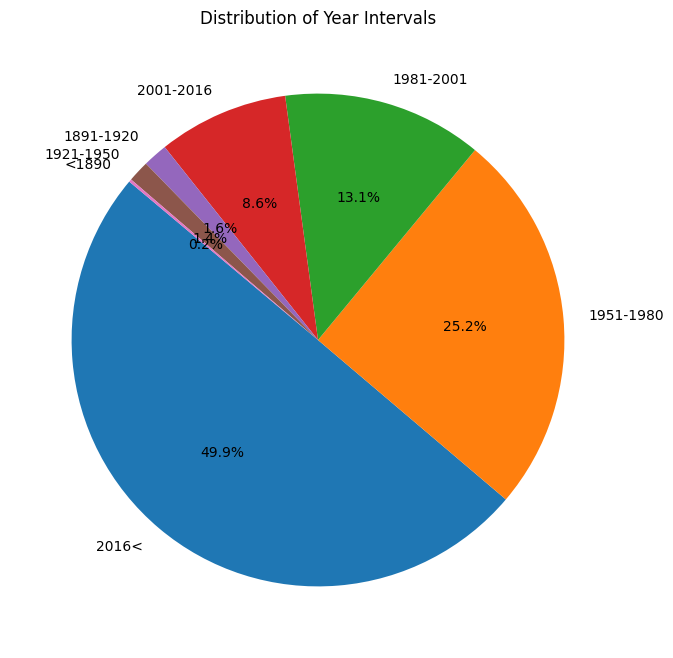

In [158]:
year_interval_counts = data['Year_interval'].value_counts()

# Create a pie plot
plt.figure(figsize=(8, 8))
plt.pie(year_interval_counts, labels=year_interval_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Year Intervals')
plt.show()

## Data preparation

In [46]:
data = pd.read_csv('data/houses_data_cleaned.csv')

In [47]:
data = data.drop("Year",axis=1)

In [48]:
# Separate target and features
target = data['Price']
features = data.drop('Price', axis=1)

In [49]:
# One-Hot Encoding for categorical variables
categorical_columns = ['Floor', 'Region', 'Year_interval']
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_cats = pd.DataFrame(
    encoder.fit_transform(features[categorical_columns]),
    columns=encoder.get_feature_names_out(categorical_columns)
)

In [50]:
# Drop original categorical columns and concatenate encoded features
features = features.drop(categorical_columns, axis=1)
features = pd.concat([features, encoded_cats], axis=1)

In [51]:
# Normalize numerical features
numerical_columns = ['Area', 'Rooms']
scaler = StandardScaler()
features[numerical_columns] = scaler.fit_transform(features[numerical_columns])

In [47]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [91]:
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 557, 2224, 557)

## Machine Learning models

### Linear Regression

Metrics: I desided to use `MAE` and $R^2$ as primary metrics, because they are easy to understand and interpret. Like secondary metrics I will use `RMSE` because this metric will penalize large errors more than MAE.

#### Build a model

In [93]:
# Build and train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### Evaluate the model

Make a function which will evaluate the model and return the metrics as dataframe.

In [13]:
def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate model performance
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    mse = round(mean_squared_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    r2 = round(r2_score(y_test, y_pred), 3)

    # Create a dataframe without MSE
    results = pd.DataFrame({
        'Metric': ['R^2', 'MAE', 'RMSE'],
        'Value': [r2, mae, rmse]
    })
    
    return results

In [95]:
results_linear_regression = evaluate_model(model, X_test, y_test)
results_linear_regression

,Metric,Value
0,R^2,0.743
1,MAE,66971.531
2,RMSE,103072.669


On average, the predictions are off by approximately 66,971 zł.The RMSE penalizes larger errors more heavily than MAE so this relatively higher value indicates on the outliers which were not removed from the data. $R^2$ indicates that 74.3% of the variance in the house prices is explained by the model.

#### SHAP analysis 

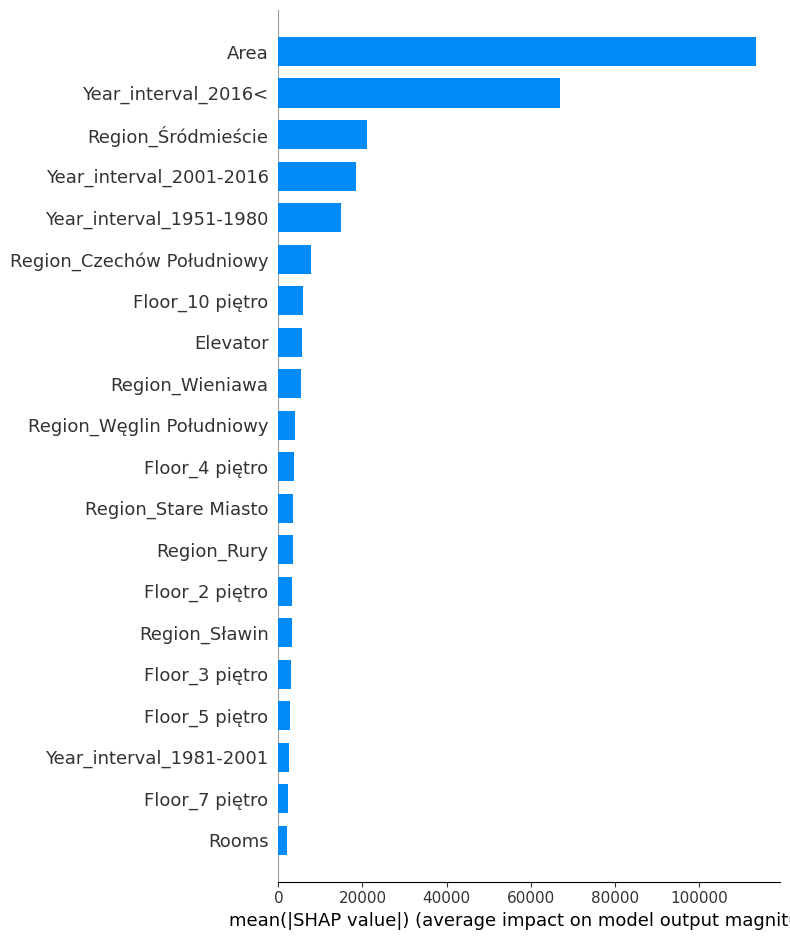

In [96]:
# SHAP analysis
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

Note that area has the highest impact on the model and it is logical, because the larger the area, the higher the price. Also year interval has very high impact on the model, especially the buildings 2001< and 1951-1980 years, 1981-2001 has much smaller impact. Elevator also has important impact on the model, rooms has very low impact, because the number of rooms depends on the area of the house. Few regions has also important impact on the model, especially Śródmieście and Czechów Południowy. Floor has very low impact, apart from the 10th floor.

Let's find the best and the worst predictions of the model.And try to analyze what variables, could have caused such a large error. And with what variables the model predicted the price very well.

In [97]:
# Predict the values
y_pred = model.predict(X_test)

# Find the best and worst predicted values
errors = np.abs(y_test.values - y_pred)
best_index = np.argmin(errors)
worst_index = np.argmax(errors)

# Print best and worst predictions
print(f"Best Prediction: Real Price: {y_test.iloc[best_index]}, Predicted Price: {y_pred[best_index]}")
print(f"Worst Prediction: Real Price: {y_test.iloc[worst_index]}, Predicted Price: {y_pred[worst_index]}")

Best Prediction: Real Price: 710000.0, Predicted Price: 709986.8920645511
Worst Prediction: Real Price: 1599000.0, Predicted Price: 1041638.9137565235


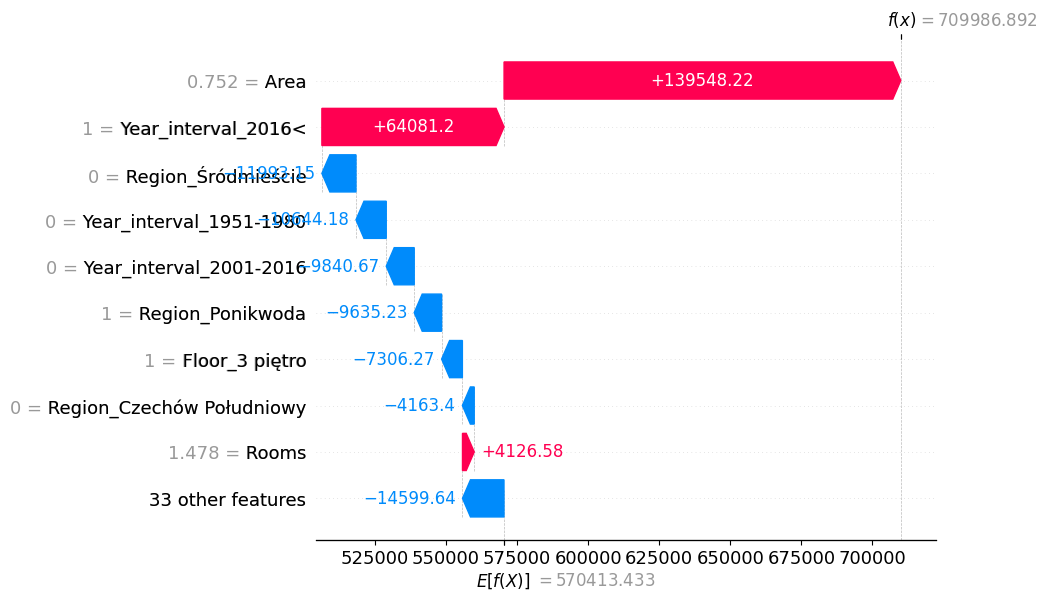

In [98]:
# Waterfall plot for best prediction
shap.waterfall_plot(shap.Explanation(values=shap_values[best_index].values, 
                                     base_values=explainer.expected_value, 
                                     data=X_test.iloc[best_index],
                                     feature_names=X_test.columns))
plt.show()

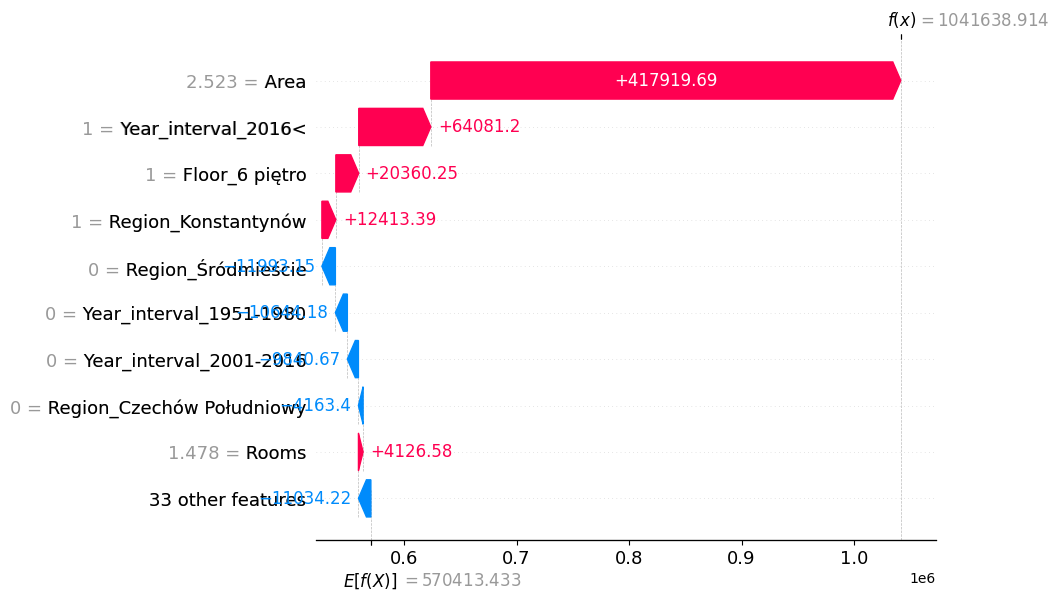

In [99]:

# Waterfall plot for worst prediction
shap.waterfall_plot(shap.Explanation(values=shap_values[worst_index].values, 
                                     base_values=explainer.expected_value, 
                                     data=X_test.iloc[worst_index]))
plt.show()

Because model had very low number of examples with very high price and large area houses, model couldn't predict that houses very well abd make very large errors, so the best solutions is to remove that outliers, but model couldn't predict well that type of houses, or another time-wasting solution is to collect more data with that type of houses.

### ElasticNet Regression 

Now let's try to use ElasticNet regression to see if it will improve the model. Also we will use GridSearchCV to find the best hyperparameters for the model.

#### Build a model

In [101]:
# ElasticNet Regression with GridSearchCV
elastic_net = ElasticNet()
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]  
}
elastic_search = GridSearchCV(elastic_net, elastic_params, cv=5, scoring='neg_mean_squared_error')
elastic_search.fit(X_train, y_train)
best_elastic = elastic_search.best_estimator_

#### Evaluate the model

In [102]:
# ElasticNet Regression Metrics
elastic_metrics = evaluate_model(best_elastic, X_test, y_test)

print("Best ElasticNet Regression Metrics (alpha={}, l1_ratio={}):".format(
    elastic_search.best_params_["alpha"], elastic_search.best_params_["l1_ratio"]), elastic_metrics)

Best ElasticNet Regression Metrics (alpha=0.1, l1_ratio=0.95):   Metric       Value
0    R^2       0.741
1    MAE   66910.695
2   RMSE  103447.970


ElasitcNet model has very similar results to the Linear Regression model, so there are no reasons to discover this model more.

### Decision Tree regression

#### Build a model

Use GridSearchCV to find the best hyperparameters for the model.

In [121]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}
decision_tree = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
grid_search.fit(X_train, y_train)
best_decision_tree = grid_search.best_estimator_
best_decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                      random_state=42)

In [122]:
# Evaluate Decision Tree
decision_tree_results = evaluate_model(best_decision_tree, X_test, y_test)
print("Decision Tree Results:")
print(decision_tree_results)

Decision Tree Results:
  Metric      Value
0    R^2      0.779
1    MAE  59267.324
2   RMSE  95701.451


Decision Tree model with GridSearchCV showed few better results than Linear Regression and ElasticNet models, but there are no reasons to discover this model more, because the results are very similar to the previous models.

### Random Forest regression

#### Build a model

In [130]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

random_forest = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
grid_search.fit(X_train, y_train)
best_random_forest = grid_search.best_estimator_
best_random_forest.fit(X_train, y_train)

RandomForestRegressor(max_features=None, min_samples_split=5, n_estimators=300,
                      random_state=42)

#### Evaluate the model

In [131]:
random_forest_results = evaluate_model(best_random_forest, X_test, y_test)
print("Random Forest Results:")
print(random_forest_results)

Random Forest Results:
  Metric      Value
0    R^2      0.820
1    MAE  48410.981
2   RMSE  86307.954


#### LIME analysis 

Worst Prediction: Real Price: 1599000.0, Predicted Price: 1041638.9137565235


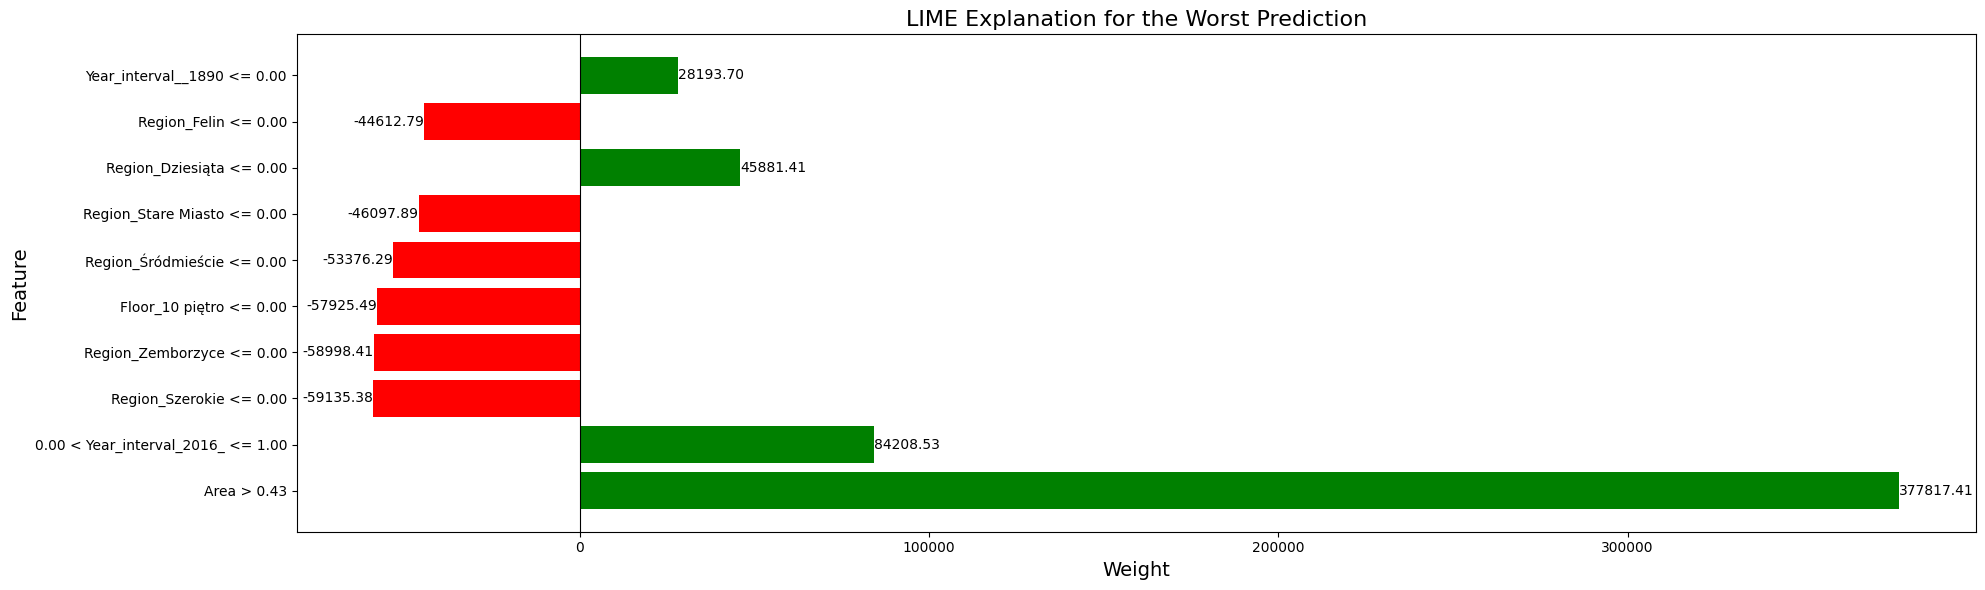

In [186]:
# Calculate errors and find the worst prediction index
errors_rf = np.abs(y_test.values - y_pred)
worst_index_rf = np.argmax(errors_rf)
print(f"Worst Prediction: Real Price: {y_test.iloc[worst_index_rf]}, Predicted Price: {y_pred[worst_index_rf]}")

# Create LIME explainer and explanation
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['Price'],
    mode='regression'
)
exp = explainer_lime.explain_instance(
    data_row=X_test.iloc[worst_index_rf].values,
    predict_fn=best_random_forest.predict
)

# Extract the explanation details
explanation = exp.as_list()
features, weights = zip(*explanation)

# Create a horizontal bar plot
plt.figure(figsize=(20, 6))
colors = ['green' if w > 0 else 'red' for w in weights]
bars = plt.barh(features, weights, color=colors)
plt.axvline(0, color='black', linewidth=0.8)  # Add a vertical line at x=0
plt.title("LIME Explanation for the Worst Prediction", fontsize=16)
plt.xlabel("Weight", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Add numbers on the side of the bars
for bar, weight in zip(bars, weights):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{weight:.2f}', 
             va='center', ha='left' if weight > 0 else 'right', color='black')

plt.tight_layout()
plt.show()

Although random forest showed better results, but for that observation from test set, the model predicted price with very large error,  so let's try to use gradient boosting model to see if it will improve the model.

### XGBoost regression 

In [152]:
# Prepare column names for XGBoost
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

#### Build a model

In [166]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}
xgb_model = XGBRegressor(random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
xgb_grid_search.fit(X_train, y_train)
best_xgb_model = xgb_grid_search.best_estimator_
print("Best parameters found: ", xgb_grid_search.best_params_)

Best parameters found:  {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.6}


The best parameters found for the XGBoost algorithm indicate a balanced approach with moderate regularization (reg_alpha and reg_lambda) and a learning rate of 0.05, which helps in preventing overfitting. The chosen parameters also suggest a focus on model robustness with a subsample and colsample_bytree of 0.6, and a max_depth of 6 to control the complexity of the trees. Maybe increasing the number of trees will improve the model, but it will take a lot of time to train the model.

#### Evaluate the model

In [167]:
xgb_results = evaluate_model(best_xgb_model, X_test, y_test)
print("XGBoost Results:")
print(xgb_results)

XGBoost Results:
  Metric      Value
0    R^2      0.841
1    MAE  50497.976
2   RMSE  81034.495


XGBoost model showed few better results than Random Forest but there are no such big improvements in metrics, so let's try to use another boosting algorithms and check how they will perform.

### LightGBM regression

#### Build a model

In [43]:
# LightGBM Regression with GridSearchCV
lgb_model = lgb.LGBMRegressor(random_state=42)
param_grid_lgb = {
    'n_estimators': [100, 200,500],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'verbose': [-1]
}
lgb_grid_search = GridSearchCV(lgb_model, param_grid_lgb, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
lgb_grid_search.fit(X_train, y_train)
best_lgb = lgb_grid_search.best_estimator_
print("Best LightGBM parameters found: ", lgb_grid_search.best_params_)


Best LightGBM parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 50, 'subsample': 0.8, 'verbose': -1}


#### Evaluate the model

In [45]:
lgbm_results = evaluate_model(best_lgb, X_test, y_test)
print("LightGBM Results:")
print(lgbm_results)

LightGBM Results:
  Metric      Value
0    R^2      0.806
1    MAE  53314.215
2   RMSE  89686.654


LightGBM model showed weaker results than XGBoost, may be better setting of hyperparameters will improve the model, but it takes a lot of time to train the model, so let's try to use CatBoost model to see how it will perform.

### CatBoost regression

#### Build a model

In [47]:
# CatBoost Regression with GridSearchCV
catboost_model = CatBoostRegressor(silent=True, random_state=42)
param_grid_catboost = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}
catboost_grid_search = GridSearchCV(catboost_model, param_grid_catboost, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
catboost_grid_search.fit(X_train, y_train)
best_catboost = catboost_grid_search.best_estimator_
print("Best CatBoost parameters found: ", catboost_grid_search.best_params_)

Best CatBoost parameters found:  {'border_count': 128, 'depth': 6, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.2}


#### Evaluate the model 

In [48]:
catboost_results = evaluate_model(best_catboost, X_test, y_test)
print("CatBoost Results:")
print(catboost_results)

CatBoost Results:
  Metric      Value
0    R^2      0.844
1    MAE  50359.185
2   RMSE  80270.363


CatBoost model showed the best results and took the least time to train the model, compared to the XGBoost algorithm which took much more time to train the model with GridSearchCV. But there are no reasons to discover this model more, because the results are not much higher than the XGBoost model.

### Support Vector Regression

#### Build a model

In [52]:
# Support Vector Regression with GridSearchCV
svr_model = SVR()
param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'epsilon': [0.1, 0.2, 0.5, 0.3]
}
svr_grid_search = GridSearchCV(svr_model, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
svr_grid_search.fit(X_train, y_train)
best_svr = svr_grid_search.best_estimator_
print("Best SVR parameters found: ", svr_grid_search.best_params_)

Best SVR parameters found:  {'C': 1000, 'degree': 2, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'linear'}


#### Evaluate the model

In [53]:
svr_results = evaluate_model(best_svr, X_test, y_test)
print("SVR Results:")
print(svr_results)

SVR Results:
  Metric       Value
0    R^2       0.673
1    MAE   69486.945
2   RMSE  116221.267


SVR showed the worst results because it struggles with large datasets and complex feature relationships, making it less suitable for this problem compared to tree-based models. Additionally, its sensitivity to outliers and hyperparameters limits its performance in this context.

## Deep learning models

### Feedforward Neural Network

#### Prepare the Data

In [125]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create PyTorch dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Define the FNN Model

In [135]:
# Define the neural network model
class FeedForwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(64, 32)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.3)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.output(x)
        return x

#### Train the Model

In [136]:
# Initialize the model
input_size = X_train.shape[1]
fnn_model = FeedForwardNN(input_size)

# Define loss and optimizer with weight decay (L2 regularization)
criterion = nn.MSELoss()
optimizer = optim.Adam(fnn_model.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay parameter

# Training loop
epochs = 1500
for epoch in range(epochs):
    fnn_model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = fnn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 100/1500, Loss: 24726117200.4571
Epoch 200/1500, Loss: 24176431469.7143
Epoch 300/1500, Loss: 23205323366.4000
Epoch 400/1500, Loss: 23314170762.9714
Epoch 500/1500, Loss: 21490440857.6000
Epoch 600/1500, Loss: 21434473267.2000
Epoch 700/1500, Loss: 21402968956.3429
Epoch 800/1500, Loss: 19943006537.1429
Epoch 900/1500, Loss: 20123715423.0857
Epoch 1000/1500, Loss: 19629415350.8571
Epoch 1100/1500, Loss: 20490149785.6000
Epoch 1200/1500, Loss: 18729567312.4571
Epoch 1300/1500, Loss: 17572003167.0857
Epoch 1400/1500, Loss: 17351312632.6857
Epoch 1500/1500, Loss: 16808496654.6286


#### Evaluate the Model

Functions to evaluate the model and return the metrics as a dataframe.

In [156]:
def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch)
            predictions.extend(outputs.flatten().tolist())
            actuals.extend(y_batch.flatten().tolist())
    return np.array(predictions), np.array(actuals)

def calculate_metrics(predictions, actuals):
    mae = round(mean_absolute_error(actuals, predictions), 3)
    mse = round(mean_squared_error(actuals, predictions), 3)
    rmse = round(np.sqrt(mse), 3)
    r2 = round(r2_score(actuals, predictions), 3)
    
    metrics_df = pd.DataFrame({
        'Metric': ['R^2', 'MAE', 'RMSE'],
        'Value': [r2, mae, rmse]
    })
    
    return metrics_df

In [163]:
# Evaluate the model
predictions, actuals = evaluate_model(fnn_model, test_loader)
fnn_results = calculate_metrics(predictions, actuals)
print(fnn_results)

  Metric      Value
0    R^2      0.812
1    MAE  58136.042
2   RMSE  88069.226


FNN model showed good results, but not better than CatBoost and XGBoost models, so there are no reasons to discover this model more. Try to use another deep learning model to see how it will perform.

### Convolutional Neural Network

#### Prepare the DataLoader

In [152]:
# Custom Dataset class
class HousingDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

# Normalize target
scaler_target = StandardScaler()
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))

# Update dataset to use scaled target
train_dataset = HousingDataset(X_train, y_train_scaled.flatten())
test_dataset = HousingDataset(X_test, y_test_scaled.flatten())

#### Define the CNN Model

In [185]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_dim):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)  
        self.fc7 = nn.Linear(16, 1)  
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.batch_norm4 = nn.BatchNorm1d(64)
        self.batch_norm5 = nn.BatchNorm1d(32)  

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm4(self.fc4(x))) 
        x = self.dropout(x)
        x = self.relu(self.batch_norm5(self.fc5(x))) 
        x = self.relu(self.fc6(x))  
        x = self.fc7(x)  
        return x.squeeze()

#### Train the Model

In [190]:
# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
fcnn_model = FullyConnectedNN(input_dim)
criterion = nn.L1Loss() 
optimizer = optim.Adam(fcnn_model.parameters(), lr=0.001)

# Training loop
epochs = 400 
for epoch in range(epochs):
    fcnn_model.train()
    total_loss = 0
    for features, target in train_loader:
        optimizer.zero_grad()
        predictions = fcnn_model(features)
        loss = criterion(predictions, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # Print loss every 50 epochs
    if (epoch + 1) % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 50/400, Loss: 515365.1978
Epoch 100/400, Loss: 193592.9949
Epoch 150/400, Loss: 71388.2740
Epoch 200/400, Loss: 61978.5732
Epoch 250/400, Loss: 58296.0185
Epoch 300/400, Loss: 57429.9431
Epoch 350/400, Loss: 55480.8816
Epoch 400/400, Loss: 54647.4089


#### Evaluate the Model

In [191]:
# Evaluate model
predictions, actuals = evaluate_model(fcnn_model, test_loader)

# Denormalize predictions and actuals
predictions_original = scaler_target.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_original = scaler_target.inverse_transform(actuals.reshape(-1, 1)).flatten()

# Calculate metrics and round the values
cnn_results = calculate_metrics(predictions_original, actuals_original)
print(cnn_results)

  Metric         Value
0    R^2  8.000000e-01
1    MAE  1.072294e+10
2   RMSE  1.817854e+10


CNN model showed the same R^2 score as the FNN, but the RMSE and MAE metrics are much higher in comparsion with other models, so СNN model does not fit this database

## Compare models results

### Dataframe with results

In [29]:
# Data from the user's input
data = {
    "Model": [
        "Linear Regression", "ElasticNet Regression", "Decision Tree Regression", 
        "Random Forest Regression", "XGBoost Regression", "LightGBM Regression", 
        "CatBoost Regression", "Support Vector Regression", 
        "Feedforward Neural Network"
    ],
    "R^2": [0.743, 0.741, 0.779, 0.820, 0.841, 0.806, 0.844, 0.673, 0.812],
    "MAE": [66971.531, 66910.695, 59267.324, 48410.981, 50497.976, 53314.215, 
            50359.185, 69486.945, 58136.042],
    "RMSE": [103072.669, 103447.970, 95701.451, 86307.954, 81034.495, 89686.654, 
             80270.363, 116221.267, 88069.226]
}

# Creating the dataframe
results_df = pd.DataFrame(data)

results_df["MAE"] = results_df["MAE"].apply(lambda x: f"{x:.2f}")
results_df["RMSE"] = results_df["RMSE"].apply(lambda x: f"{x:.2f}")
results_df["MAE"] = results_df["MAE"].astype(float)
results_df["RMSE"] = results_df["RMSE"].astype(float)
results_df

,Model,R^2,MAE,RMSE
0,Linear Regression,0.743,66971.53,103072.67
1,ElasticNet Regression,0.741,66910.70,103447.97
2,Decision Tree Regression,0.779,59267.32,95701.45
3,Random Forest Regression,0.820,48410.98,86307.95
4,XGBoost Regression,0.841,50497.98,81034.49
5,LightGBM Regression,0.806,53314.21,89686.65
6,CatBoost Regression,0.844,50359.18,80270.36
7,Support Vector Regression,0.673,69486.95,116221.27
8,Feedforward Neural Network,0.812,58136.04,88069.23


### Visualize the results

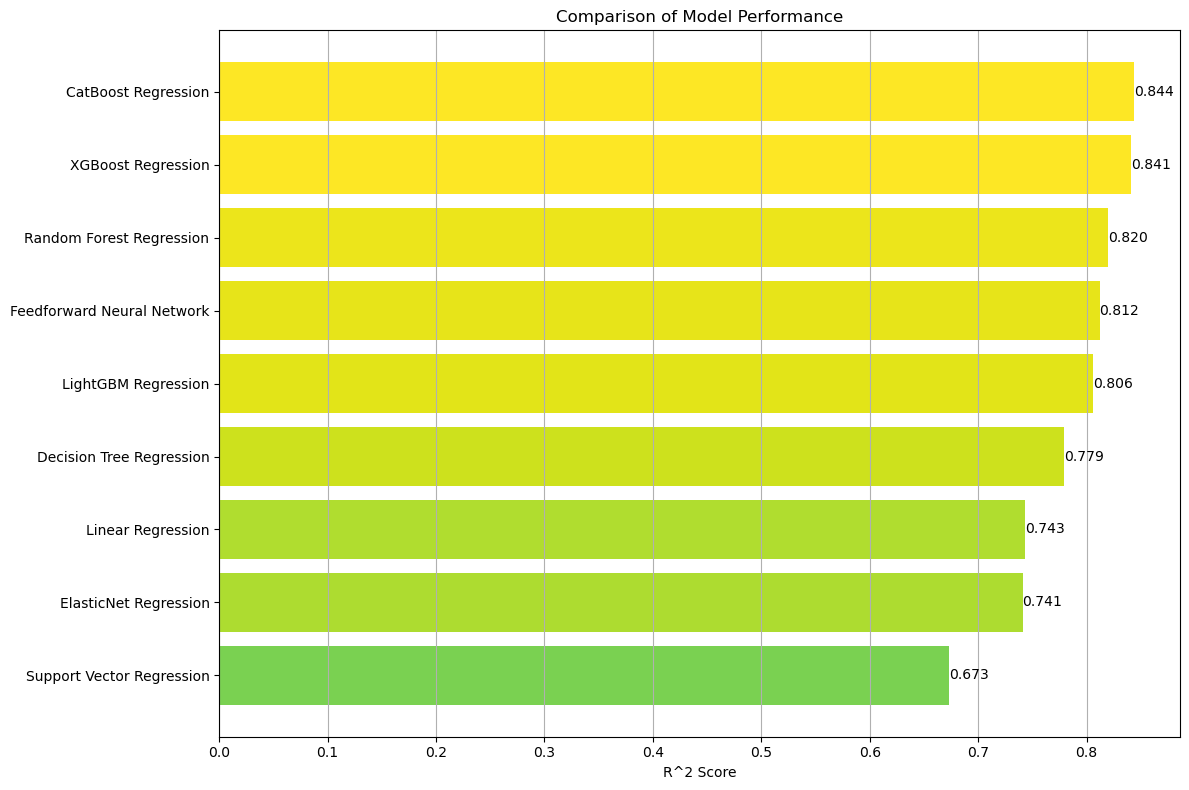

In [31]:
# Sort the dataframe by R^2 in ascending order
results_df_sorted = results_df.sort_values(by="R^2")

# Plot the bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(results_df_sorted["Model"], results_df_sorted["R^2"], color=plt.cm.viridis(results_df_sorted["R^2"] / max(results_df_sorted["R^2"])))
plt.xlabel("R^2 Score")
plt.title("Comparison of Model Performance")
plt.grid(axis='x')

# Add the R^2 values on the bars
for bar, r2 in zip(bars, results_df_sorted["R^2"]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{r2:.3f}', 
             va='center', ha='left', color='black')

plt.tight_layout()
plt.show()

Boosting algorithms showed the best results, Random Forest and FNN also showed good results.

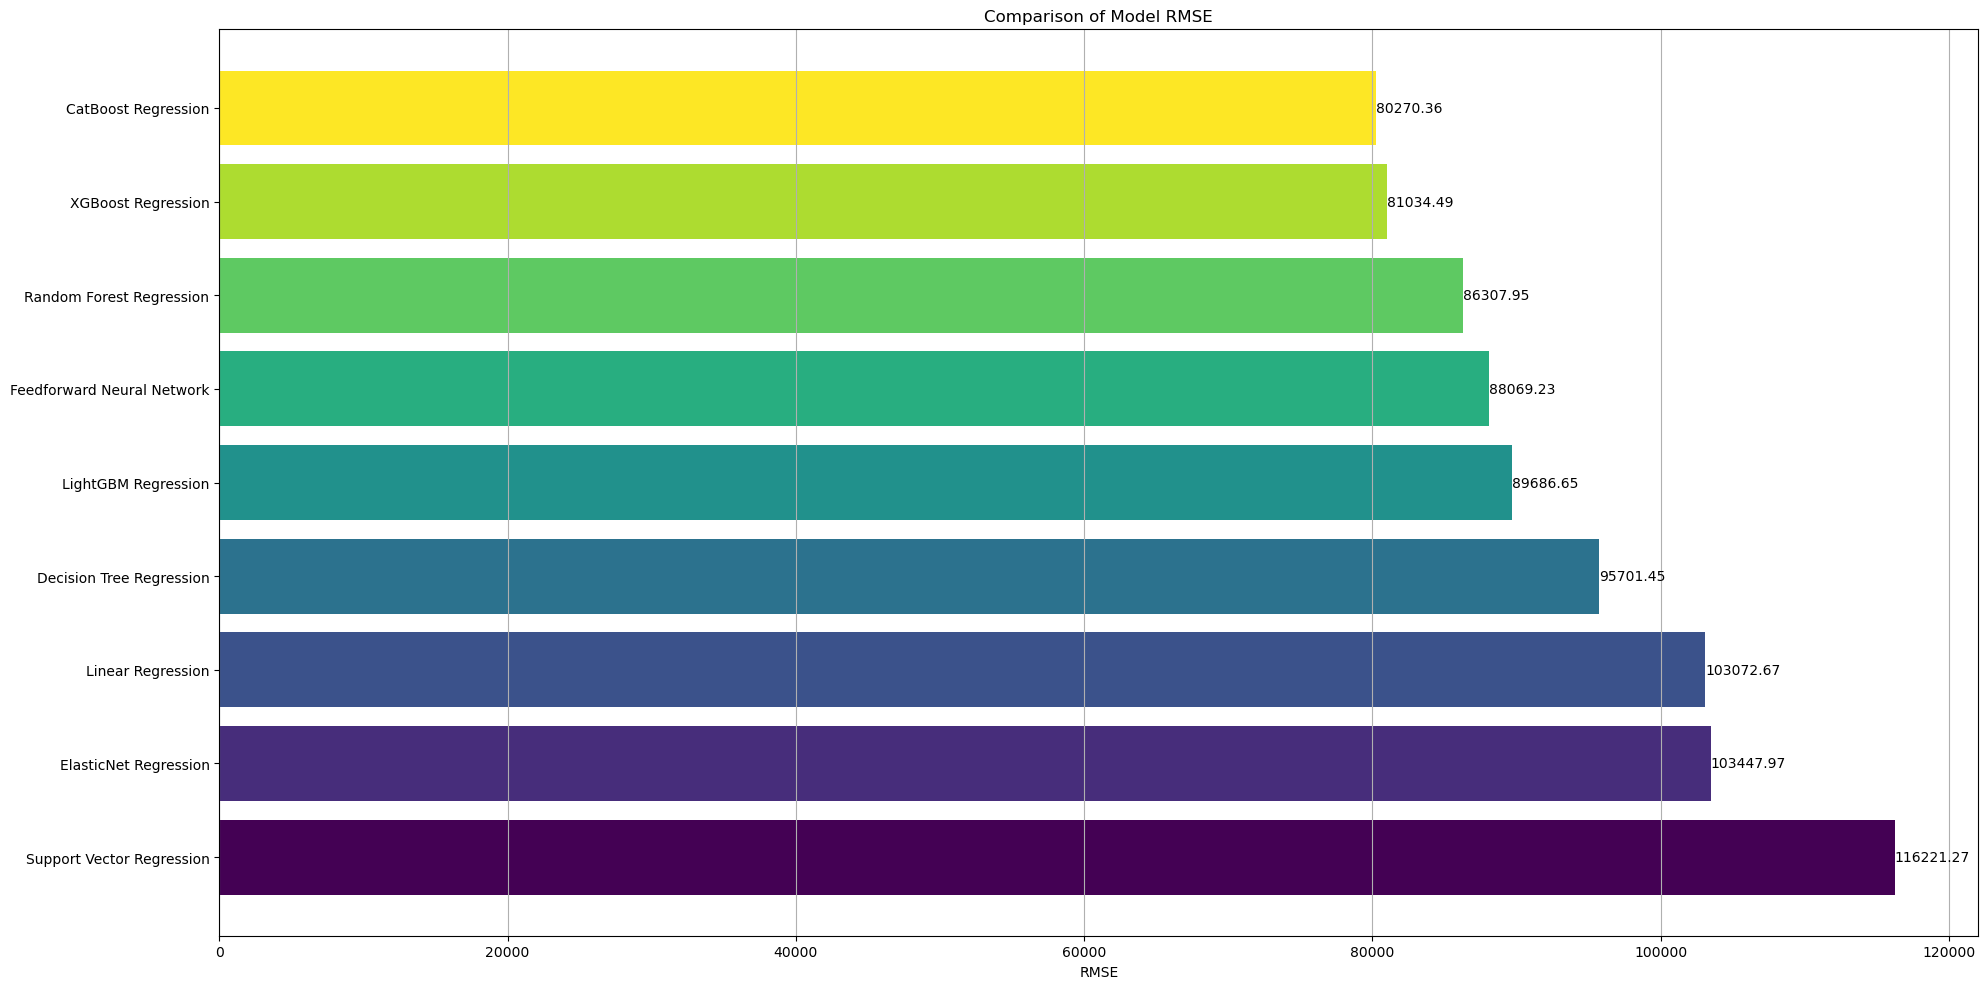

In [33]:
# Sort the dataframe by RMSE in descending order
results_df_sorted_rmse = results_df.sort_values(by="RMSE",ascending=False)

# Plot the bar chart
plt.figure(figsize=(20, 10))  # Increase the figure size
bars = plt.barh(results_df_sorted_rmse["Model"], results_df_sorted_rmse["RMSE"].astype(float), 
                color=plt.cm.viridis(np.linspace(0, 1, len(results_df_sorted_rmse))))
plt.xlabel("RMSE")
plt.title("Comparison of Model RMSE")
plt.grid(axis='x')

# Add the RMSE values on the bars
for bar, rmse in zip(bars, results_df_sorted_rmse["RMSE"]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{rmse}', 
             va='center', ha='left', color='black')

plt.tight_layout()
plt.show()

Like with R^2 boosting algorithms showed the lowest RMSE values, Random Forest and FNN also showed good results.

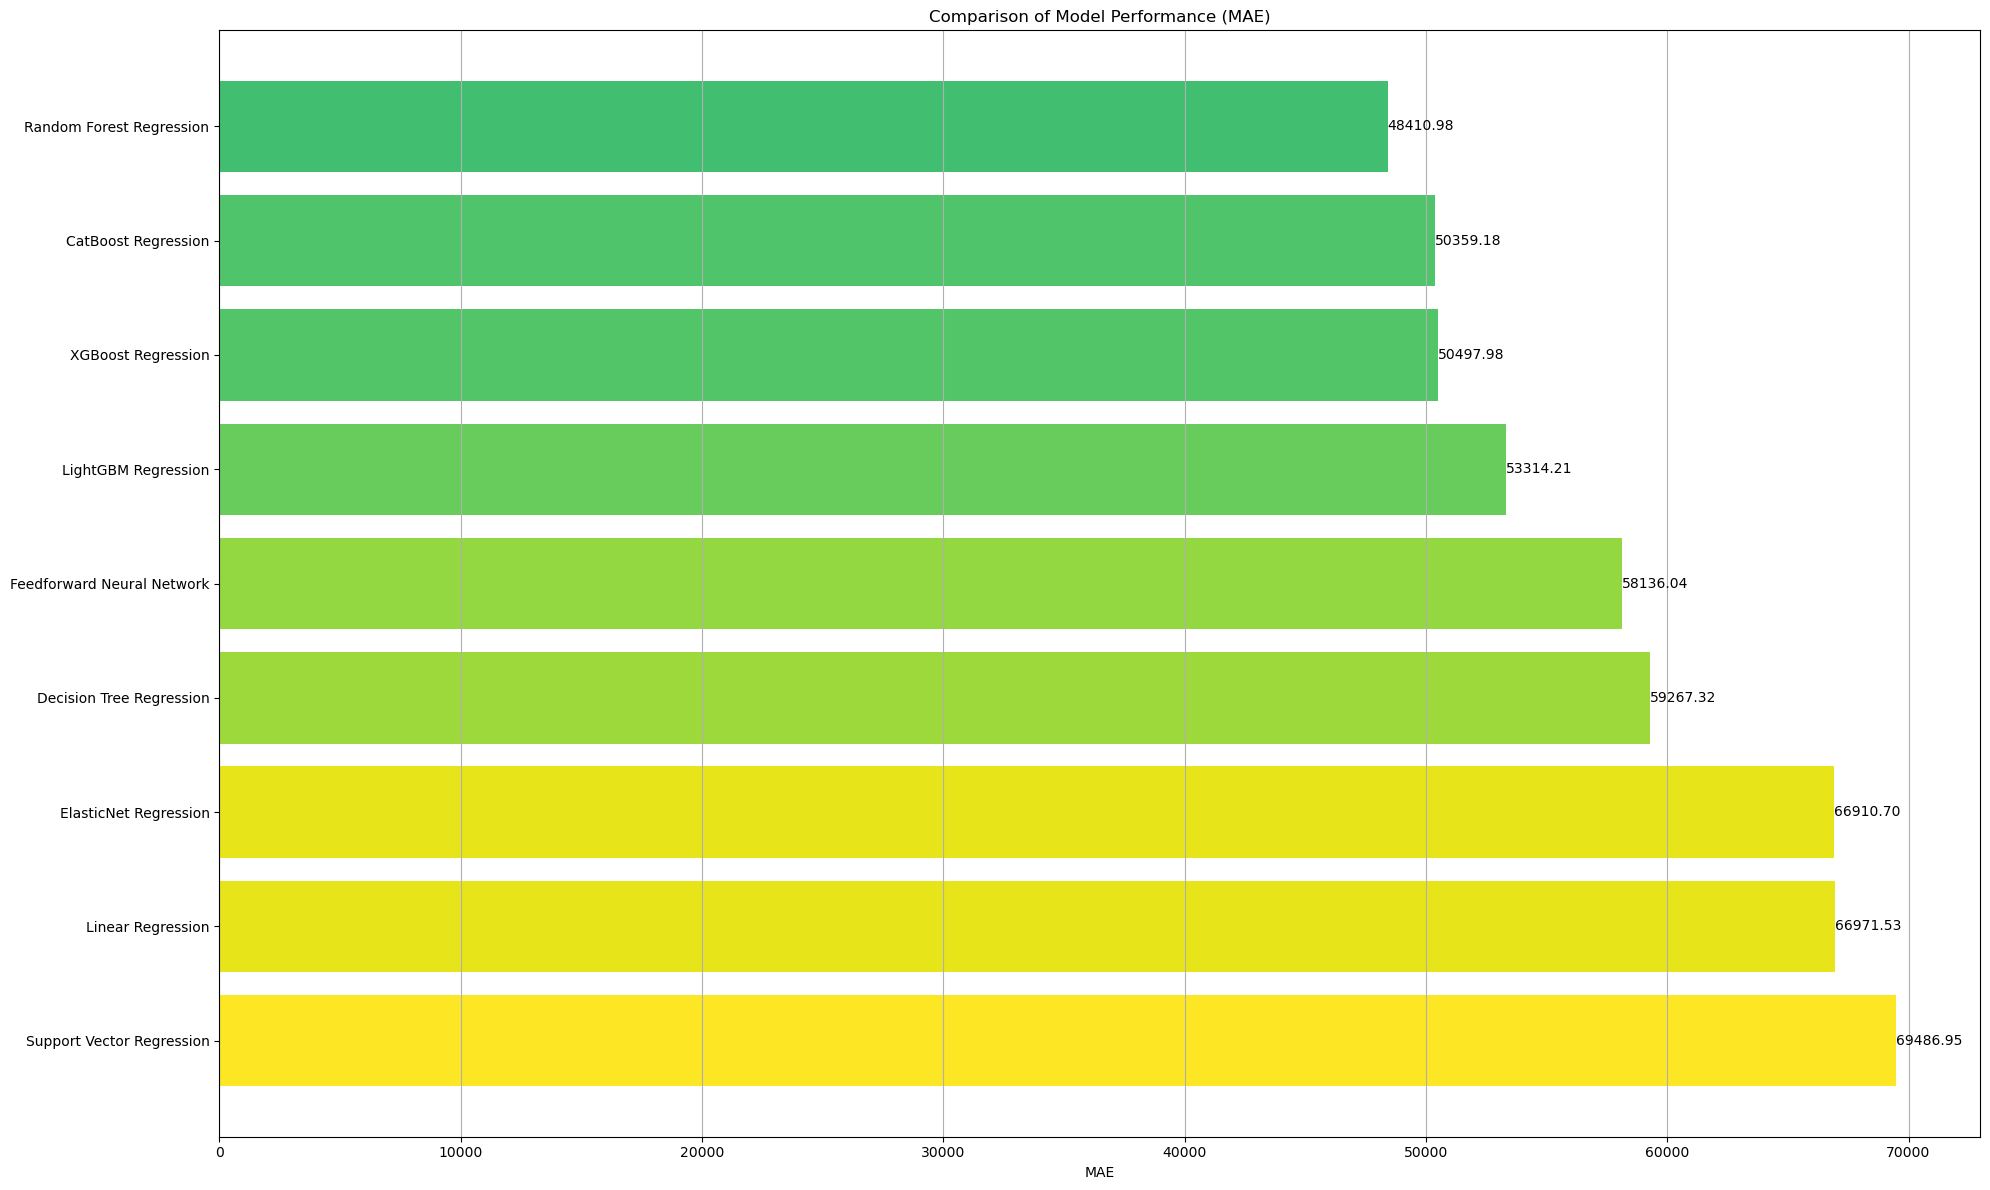

In [36]:
# Sort the dataframe by MAE in ascending order
results_df_sorted_mae = results_df.sort_values(by="MAE",ascending=False)

# Plot the bar chart
plt.figure(figsize=(20, 12)) 
bars = plt.barh(results_df_sorted_mae["Model"], results_df_sorted_mae["MAE"], color=plt.cm.viridis(results_df_sorted_mae["MAE"] / max(results_df_sorted_mae["MAE"])))
plt.xlabel("MAE")
plt.title("Comparison of Model Performance (MAE)")
plt.grid(axis='x')

# Add the MAE values on the bars
for bar, mae in zip(bars, results_df_sorted_mae["MAE"]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{mae:.2f}', 
             va='center', ha='left', color='black')

plt.tight_layout()
plt.show()

By MAE metrics Random Forest showed the best results, boosting algorithms showed few worse results, but still very good.

## AutoML with PyCaret

Code migrated from google collab where other versions of libraries were used

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from pycaret.regression import setup, compare_models, pull

# # Load the cleaned data
# data = pd.read_csv('data/houses_data_cleaned.csv') # not that
data = pd.read_csv('houses_data_cleaned.csv')

# Drop unnecessary columns
data = data.drop("Year", axis=1)

# Separate target and features
target = data['Price']
features = data.drop('Price', axis=1)

# One-Hot Encoding for categorical variables
categorical_columns = ['Floor', 'Region', 'Year_interval']
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_cats = pd.DataFrame(
    encoder.fit_transform(features[categorical_columns]),
    columns=encoder.get_feature_names_out(categorical_columns)
)

# Drop original categorical columns and concatenate encoded features
features = features.drop(categorical_columns, axis=1)
features = pd.concat([features, encoded_cats], axis=1)

# Normalize numerical features
numerical_columns = ['Area', 'Rooms']
scaler = StandardScaler()
features[numerical_columns] = scaler.fit_transform(features[numerical_columns])

# Combine features and target for AutoML
data_for_pycaret = pd.concat([features, target], axis=1)

# AutoML using PyCaret
regression_setup = setup(data=data_for_pycaret, target='Price', session_id=42, normalize=False)

# Compare models
best_model = compare_models()

# Display comparison metrics
results = pull()
print("Comparison Results:")
print(results)

# Finalize the best model
final_model = best_model

,Description,Value
0,Session id,42
1,Target,Price
2,Target type,Regression
3,Original data shape,"(2781, 43)"
4,Transformed data shape,"(2781, 43)"
5,Transformed train set shape,"(1946, 43)"
6,Transformed test set shape,"(835, 43)"
7,Numeric features,42
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,47500.0191,8030039683.3865,88646.4854,0.7720,0.1326,0.0807,1.0390
rf,Random Forest Regressor,50538.7180,8304011893.5480,90414.7969,0.7606,0.1335,0.0851,0.8970
lightgbm,Light Gradient Boosting Machine,56423.0470,8761743366.7011,92537.2164,0.7528,0.1341,0.0950,0.1790
gbr,Gradient Boosting Regressor,61547.6105,9194396367.8639,95197.5473,0.7381,0.1421,0.1055,0.2620
br,Bayesian Ridge,67640.8336,10832816179.2000,103298.1367,0.6950,0.1517,0.1152,0.0390
ridge,Ridge Regression,67704.0652,10850814924.8000,103386.3312,0.6943,0.1523,0.1153,0.0340
lasso,Lasso Regression,67839.9352,10905300480.0000,103632.7570,0.6926,0.1530,0.1156,0.0730
llar,Lasso Least Angle Regression,67839.9344,10905300787.2000,103632.7672,0.6926,0.1530,0.1156,0.0430
lr,Linear Regression,67842.3363,10905843404.8000,103635.0992,0.6925,0.1530,0.1156,0.6150
huber,Huber Regressor,64530.1149,11157665126.7724,104666.5622,0.6884,0.1474,0.1064,0.0920


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Comparison Results:
                                    Model          MAE           MSE  \
et                  Extra Trees Regressor   47500.0191  8.030040e+09   
rf                Random Forest Regressor   50538.7180  8.304012e+09   
lightgbm  Light Gradient Boosting Machine   56423.0470  8.761743e+09   
gbr           Gradient Boosting Regressor   61547.6105  9.194396e+09   
br                         Bayesian Ridge   67640.8336  1.083282e+10   
ridge                    Ridge Regression   67704.0652  1.085081e+10   
lasso                    Lasso Regression   67839.9352  1.090530e+10   
llar         Lasso Least Angle Regression   67839.9344  1.090530e+10   
lr                      Linear Regression   67842.3363  1.090584e+10   
huber                     Huber Regressor   64530.1149  1.115767e+10   
knn                 K Neighbors Regressor   63471.7668  1.116798e+10   
par          Passive Aggressive Regressor   68122.8329  1.237912e+10   
omp           Orthogonal Matching Pursuit   

Extra Tree Regressor showed the best results in the AutoML model, the MAE metric is the lowest, but R^2 and RMSE metrics are higher than in the CatBoost model. So it is good idea to test that model, on the whole dataset, but before that we need to remove outliers from the data or add more examples of large buildings to the data

## Final model

Build a model on the whole dataset with CatBoost model, because it showed the best results in the previous models. 

### Data preparation

In [4]:
data = pd.read_csv('data/houses_data_cleaned.csv')
data = data.drop("Year",axis=1)

# Separate target and features
target = data['Price']
features = data.drop('Price', axis=1)

# One-Hot Encoding for categorical variables
categorical_columns = ['Floor', 'Region', 'Year_interval']
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_cats = pd.DataFrame(
    encoder.fit_transform(features[categorical_columns]),
    columns=encoder.get_feature_names_out(categorical_columns)
)

# Drop original categorical columns and concatenate encoded features
features = features.drop(categorical_columns, axis=1)
features = pd.concat([features, encoded_cats], axis=1)

# Normalize numerical features
numerical_columns = ['Area', 'Rooms']
scaler = StandardScaler()
features[numerical_columns] = scaler.fit_transform(features[numerical_columns])

### Build a model

In [20]:
# Prepare the entire dataset for training
X = features
y = target

In [10]:
# Define the CatBoost regressor
catboost_model = CatBoostRegressor(silent=True)

# Define hyperparameters for GridSearch
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring='r2', cv=5, verbose=1)
grid_search.fit(X, y)

# Output the best parameters and the best score
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best R^2 Score from GridSearchCV:", grid_search.best_score_)

# Train the model with the best parameters on the entire dataset
final_model = CatBoostRegressor(**best_params, silent=True)
final_model.fit(X, y)

# Predict on the training data (to evaluate the fit on the whole dataset)
y_pred = final_model.predict(X)

# Calculate R^2 and Adjusted R^2
r2 = r2_score(y, y_pred)
n = X.shape[0]  # Number of observations
p = X.shape[1]  # Number of predictors (features)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("R^2 Score on the entire dataset:", r2)
print("Adjusted R^2 Score on the entire dataset:", adjusted_r2)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Best R^2 Score from GridSearchCV: 0.7789483383340924
R^2 Score on the entire dataset: 0.9093910814512892
Adjusted R^2 Score on the entire dataset: 0.9080011710864075


In [ ]:
# Save the scaler object
joblib.dump(scaler, 'model_components/scaler.joblib')

In [54]:
# Save the columns of X
joblib.dump(X.columns, 'model_components/X_columns.joblib')

['X_columns.joblib']

In [9]:
# Save the y column
joblib.dump(y, 'model_components/y.joblib')

['y.joblib']

In [24]:
joblib.dump(y_pred, 'model_components/y_pred.joblib')

['y_pred.joblib']

### Test model on different data

In [18]:
def predict_house_price(model,area, elevator, rooms, floor, region, year_of_building):
    """
    Predicts and prints the price of a house based on the input values.

    Parameters:
    - model: The trained machine learning model.
    - area (float): The area of the house in square meters.
    - elevator (int): 1 if the house has an elevator, 0 otherwise.
    - rooms (int): Number of rooms in the house.
    - floor (int): The floor number (e.g., 0 for 'parter', 1 for '1 piętro', etc.).
    - region (str): The region where the house is located.
    - year_of_building (int): The year the house was built (e.g., 1985, 2010).

    Returns:
    - predicted_price (float): The predicted price of the house.
    """
    # Map floor number to corresponding category
    if floor == 0:
        floor_category = 'parter'
    elif floor <= 10:
        floor_category = f'{floor} piętro'
    else:
        floor_category = '10 piętro'

    # Map year_of_building to corresponding year interval
    if year_of_building < 1890:
        year_interval_category = '<1890'
    elif 1890 <= year_of_building <= 1920:
        year_interval_category = '1890-1920'
    elif 1921 <= year_of_building <= 1950:
        year_interval_category = '1921-1950'
    elif 1951 <= year_of_building <= 1980:
        year_interval_category = '1951-1980'
    elif 1981 <= year_of_building <= 2001:
        year_interval_category = '1981-2001'
    elif 2002 <= year_of_building <= 2016:
        year_interval_category = '2001-2016'
    else:
        year_interval_category = '2016<'

    # Initialize an empty DataFrame with the structure of X
    input_data = pd.DataFrame(columns=X.columns)
    
    # Fill in the numerical features
    input_data.loc[0, 'Area'] = area
    input_data.loc[0, 'Elevator'] = elevator
    input_data.loc[0, 'Rooms'] = rooms

    # Fill in the one-hot encoded categorical features
    if f'Floor_{floor_category}' in input_data.columns:
        input_data.loc[0, f'Floor_{floor_category}'] = 1
    if f'Region_{region}' in input_data.columns:
        input_data.loc[0, f'Region_{region}'] = 1
    if f'Year_interval_{year_interval_category}' in input_data.columns:
        input_data.loc[0, f'Year_interval_{year_interval_category}'] = 1

    # Replace NaN values with 0 for one-hot encoded features
    input_data = input_data.fillna(0)

    # Normalize numerical features
    input_data[numerical_columns] = scaler.transform(input_data[numerical_columns])

    # Predict the price
    predicted_price = model.predict(input_data)

    # Print the result
    print(f"The predicted price for the house is: {predicted_price[0]:,.2f}")
    
    return predicted_price[0]

In [13]:
# Function for Individual Prediction Confidence Interval
def calculate_individual_confidence_interval(y_true, y_pred, prediction, alpha=0.05):
    """
    Calculates the 95% confidence interval for an individual prediction.

    Parameters:
    - y_true: The true target values.
    - y_pred: The predicted target values.
    - prediction: The predicted value for the individual instance.
    - alpha: The significance level (default is 0.05 for 95% confidence).

    Returns:
    - lower_bound: The lower bound of the confidence interval for the individual prediction.
    - upper_bound: The upper bound of the confidence interval for the individual prediction.
    """
    # Calculate residuals
    residuals = y_true - y_pred
    
    # Calculate standard error of residuals
    standard_error = np.std(residuals, ddof=1)
    
    # Compute the margin of error for the prediction
    margin_of_error = norm.ppf(1 - alpha / 2) * standard_error
    
    # Calculate confidence interval
    lower_bound = prediction - margin_of_error
    upper_bound = prediction + margin_of_error

    return lower_bound, upper_bound

In [30]:
predict_house_price(final_model,area=85.0, elevator=1, rooms=4, floor=3, region='Rury', year_of_building=1995)

The predicted price for the house is: 862,487.62


862487.6166860636

### Save the model

In [31]:
import joblib
# Save the final model
joblib.dump(final_model, "model_components/final_catboost_model.joblib")

['final_catboost_model.joblib']

### Load the model

In [16]:
# Load the model
loaded_model = joblib.load("model_components/final_catboost_model.joblib")

In [33]:
predict_house_price(loaded_model,area=85.0, elevator=1, rooms=4, floor=3, region='Rury', year_of_building=1995)

The predicted price for the house is: 862,487.62


862487.6166860636

Test predict_house_price() function with the loaded model.

In [44]:
predict_house_price(loaded_model,area=59.36, elevator=1, rooms=3, floor=4, region='Węglin Południowy', year_of_building=2016)

The predicted price for the house is: 678,232.12


678232.1153098935

Test calculate_individual_confidence_interval() function with the loaded model.

In [23]:
individual_prediction = predict_house_price(loaded_model, area=85.0, elevator=1, rooms=4, floor=3, region='Rury', year_of_building=1995)

# Calculate the confidence interval for the individual prediction
lower, upper = calculate_individual_confidence_interval(y, y_pred, individual_prediction)

print(f"95% Confidence Interval for the prediction: [{lower:,.2f}, {upper:,.2f}]")

The predicted price for the house is: 862,487.62
95% Confidence Interval for the prediction: [744,183.48, 980,791.75]


## Experiment with RMSLE loss function

### Data preparation

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
data = pd.read_csv('data/houses_data_cleaned.csv')
data = data.drop("Year",axis=1)
# Separate target and features
target = data['Price']
features = data.drop('Price', axis=1)
# One-Hot Encoding for categorical variables
categorical_columns = ['Floor', 'Region', 'Year_interval']
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_cats = pd.DataFrame(
    encoder.fit_transform(features[categorical_columns]),
    columns=encoder.get_feature_names_out(categorical_columns)
)
# Drop original categorical columns and concatenate encoded features
features = features.drop(categorical_columns, axis=1)
features = pd.concat([features, encoded_cats], axis=1)
# Normalize numerical features
numerical_columns = ['Area', 'Rooms']
scaler = StandardScaler()
features[numerical_columns] = scaler.fit_transform(features[numerical_columns])
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 557, 2224, 557)

### CatBoost model with RMSLE loss function

In [4]:
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV

# Define RMSLE function
def rmsle(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

# Create custom RMSLE scorer
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)  # For minimization

In [8]:
from tqdm import tqdm
import time
from sklearn.model_selection import ParameterGrid

# Measure time
start_time = time.time()

# Total number of parameter combinations
total_combinations = len(list(ParameterGrid(param_grid)))

print(f"Total parameter combinations to check: {total_combinations}")

# Initialize progress bar
progress_bar = tqdm(total=total_combinations, desc="Tuning Parameters")

# Custom loop for GridSearchCV with progress tracking
best_score = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    # Update CatBoost model with current parameters
    model = CatBoostRegressor(loss_function="RMSE", verbose=0, **params)
    
    # Fit model
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate RMSLE
    current_score = rmsle(y_test, y_pred)
    
    # Update best score and parameters if current is better
    if current_score < best_score:
        best_score = current_score
        best_params = params
    
    # Update progress bar
    progress_bar.update(1)

# Close progress bar
progress_bar.close()

# End timing
end_time = time.time()
elapsed_time = end_time - start_time

# Output results
print("\nTuning completed!")
print(f"Best Parameters: {best_params}")
print(f"Best RMSLE: {best_score:.4f}")
print(f"Time taken: {elapsed_time:.2f} seconds")

# Evaluate the best model on the test set
best_model = CatBoostRegressor(loss_function="RMSE", verbose=0, **best_params)
best_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)
y_pred = best_model.predict(X_test)

# Calculate and display final metrics
test_rmsle = rmsle(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nFinal Test Metrics:")
print(f"  R²: {test_r2:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  RMSLE: {test_rmsle:.4f}")

Total parameter combinations to check: 36864


Tuning Parameters: 100%|██████████| 36864/36864 [11:55:52<00:00,  1.17s/it]  



Tuning completed!
Best Parameters: {'bagging_temperature': 0, 'border_count': 128, 'depth': 8, 'grow_policy': 'Depthwise', 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.2, 'random_strength': 3}
Best RMSLE: 0.1080
Time taken: 42952.64 seconds

Final Test Metrics:
  R²: 0.8532
  MAE: 45660.5947
  RMSE: 77927.0109
  RMSLE: 0.1080


### FNN model with RMSLE loss function

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_log_error
import time

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) 
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [81]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define RMSLE loss function
class RMSLELoss(nn.Module):
    def forward(self, y_pred, y_true):
        log_y_pred = torch.log1p(torch.clamp(y_pred, min=0))
        log_y_true = torch.log1p(y_true)
        return torch.sqrt(torch.mean((log_y_pred - log_y_true) ** 2))

Using device: cuda


In [82]:
import torch.nn.functional as F

class ComplexFNN(nn.Module):
    def __init__(self, input_dim):
        super(ComplexFNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256), 
            nn.ReLU(),
            nn.Dropout(0.4), 

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1) 
        )
    
    def forward(self, x):
        return self.network(x)

cmodel = ComplexFNN(input_dim=X_train.shape[1]).to(device)
loss_fn = RMSLELoss()  # RMSLE as the loss function
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Reduce learning rate

In [83]:
# Prepare data loaders
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

In [84]:
# Training loop
epochs = 300
start_time = time.time()
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        predictions = model(X_batch)
        loss = loss_fn(predictions, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")



Epoch 50/300, Loss: 0.1570
Epoch 100/300, Loss: 0.1545
Epoch 150/300, Loss: 0.1537
Epoch 200/300, Loss: 0.1528
Epoch 250/300, Loss: 0.1507
Epoch 300/300, Loss: 0.1462


In [85]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        predictions = model(X_batch).cpu().numpy()
        y_pred.extend(predictions.flatten())
        y_true.extend(y_batch.cpu().numpy().flatten())

# Calculate RMSLE on test data
test_rmsle = torch.sqrt(torch.tensor(mean_squared_log_error(y_true, y_pred), dtype=torch.float32))
print(f"Test RMSLE: {test_rmsle.item():.4f}")

# Calculate additional metrics
test_r2 = r2_score(y_true, y_pred)
test_mae = mean_absolute_error(y_true, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("\nFinal Test Metrics:")
print(f"  R²: {test_r2:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  RMSLE: {test_rmsle.item():.4f}")

# Output time taken
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining Time: {elapsed_time:.2f} seconds")

Test RMSLE: 0.1236

Final Test Metrics:
  R²: 0.8056
  MAE: 55417.0820
  RMSE: 89681.1406
  RMSLE: 0.1236

Training Time: 164.70 seconds


CatBoost model showed the best results, with RMSLE loss function and teach the final model with that loss function and new hyperparameters on the whole data would improwe the model.